In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
from scipy import stats
from sklearn import model_selection, linear_model, metrics, tree
from sklearn.calibration import calibration_curve
import os
from google.colab import drive
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
sns.set_theme(style="whitegrid")
matplotlib.rc_file_defaults()
drive.mount('/content/drive')

Mounted at /content/drive


# Load in Data

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/CSE 283/GSE131512-tpm-data.tsv', sep='\t', index_col=1)
del data['ProbeID']

cancer_data = data.iloc[:,:97]

sample_table = pd.read_csv('/content/drive/Shareddrives/CSE 283/cancerLabels.csv', index_col=0)
sample_table['recur'] = sample_table['Recurrence Status'].str.contains('R')
sample_table['nonrecur'] = sample_table['Recurrence Status'].str.contains('N')
sample_table = sample_table.rename({'Recurrence Status':'Recurrence'}, axis=1)


#Results HR-

## Logistic Regression Classifier Heatmaps

All genes Logistic Regression HR-


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy       0.700000
Sensitivity    0.600000
Specificity    0.800000
Precision      0.750000
F1 Score       0.666667
MCC            0.408248
dtype: float64



ICS-5 Logistic Regression HR-


Accuracy       0.800000
Sensitivity    0.600000
Specificity    1.000000
Precision      1.000000
F1 Score       0.750000
MCC            0.654654
dtype: float64



IR-7 Logistic Regression HR-


Accuracy       0.700000
Sensitivity    0.600000
Specificity    0.800000
Precision      0.750000
F1 Score       0.666667
MCC            0.408248
dtype: float64

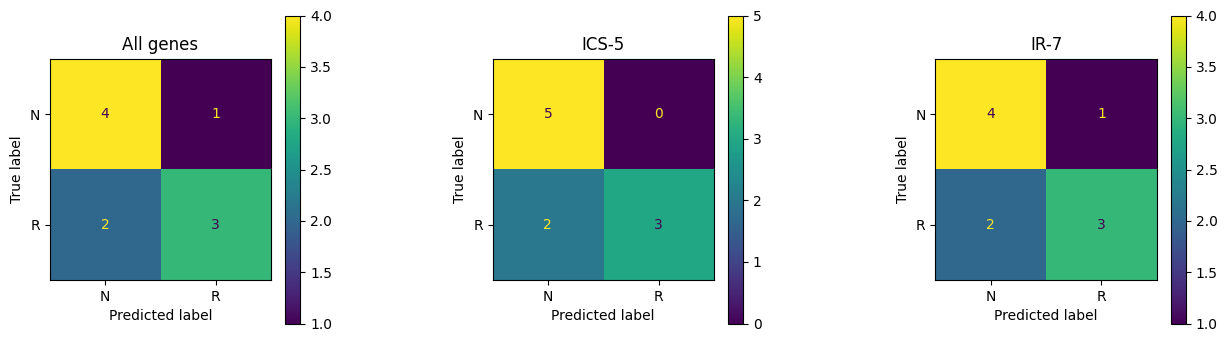

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

fig, ax = plt.subplots(1, len(gene_list), figsize = (len(gene_list)*5, 4))
plt.subplots_adjust(wspace = 0.6)

for name, genes in gene_list.items():

  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]

  # train the model
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)

  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)
  
  disp = plot_confusion_matrix(lr, condition1_data[test_samp].T, test_labels, ax=ax[count])
  disp.ax_.set_title(name)

  #print(name)
  #print(disp.confusion_matrix)

  cm = confusion_matrix(test_labels, lr_predictions)
  confusion = pd.DataFrame(cm, 
                          index=['True: N', 'True: R'], 
                          columns=['Pred: N', 'Pred: R'])

  confusion.loc['Total'] = confusion.sum()
  confusion['Total'] = confusion.sum(axis = 1)
  
  performance_res = pd.Series(dtype = float,
                            index = ['Accuracy', 'Sensitivity', 
                                     'Specificity', 'Precision',
                                    'F1 Score', 'MCC'])

  # get the needed values
  tp = confusion.loc['True: R', 'Pred: R']
  tn = confusion.loc['True: N', 'Pred: N']
  fp = confusion.loc['True: N', 'Pred: R']
  fn = confusion.loc['True: R', 'Pred: N']
  all_ = confusion.loc['Total', 'Total']

  # compute statistics
  performance_res['Accuracy'] = (tp + tn)/all_
  performance_res['Sensitivity'] = tp/(tp + fn)
  performance_res['Specificity'] = tn/(tn + fp)
  performance_res['Precision'] = tp/(tp + fp)
  performance_res['F1 Score'] = tp/(tp + 0.5*(fp+fn))
  performance_res['MCC'] = metrics.matthews_corrcoef(test_labels, lr_predictions)

  # display
  print(name, 'Logistic Regression HR-')
  display(performance_res)
  print('\n')

  count += 1

plt.show()


## SVC Classifier Heatmaps

All genes SVC HR-


Accuracy       0.700000
Sensitivity    0.600000
Specificity    0.800000
Precision      0.750000
F1 Score       0.666667
MCC            0.600000
dtype: float64



ICS-5 SVC HR-


Accuracy       0.700000
Sensitivity    0.600000
Specificity    0.800000
Precision      0.750000
F1 Score       0.666667
MCC            0.000000
dtype: float64



IR-7 SVC HR-


Accuracy       0.700000
Sensitivity    0.600000
Specificity    0.800000
Precision      0.750000
F1 Score       0.666667
MCC            0.654654
dtype: float64

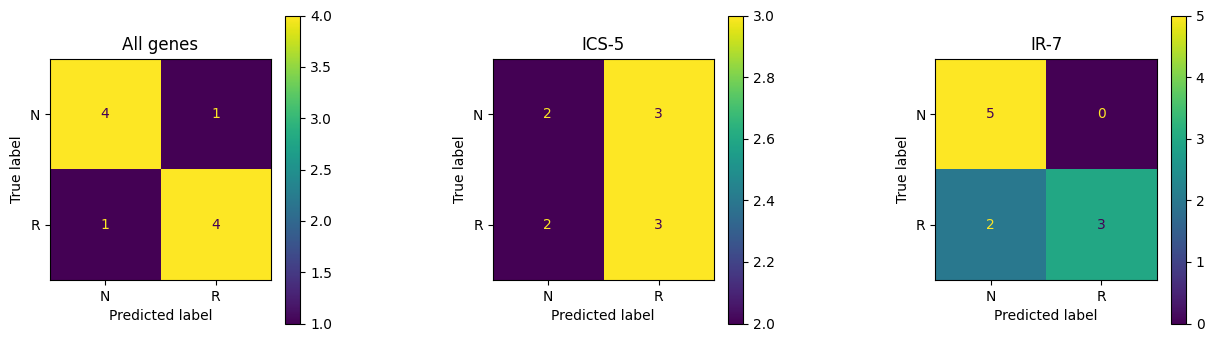

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

fig, ax = plt.subplots(1, len(gene_list), figsize = (len(gene_list)*5, 4))
plt.subplots_adjust(wspace = 0.6)

for name, genes in gene_list.items():

  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]

  # train the model
  svc_model = SVC(kernel = 'linear', probability=True)
  svc_model_rbf = SVC(kernel = 'rbf', gamma='scale', probability=True)
  sv = svc_model.fit(condition1_data[train_samp].T, train_labels)
  sv_rbf = svc_model_rbf.fit(condition1_data[train_samp].T, train_labels)

  # predict class labels for the testing set
  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)
  sv_predictions_rbf = sv_rbf.predict(condition1_data[test_samp].T)
  sv_predictions_rbf = pd.Series(sv_predictions_rbf, index = test_samp)
  
  disp = plot_confusion_matrix(sv, condition1_data[test_samp].T, test_labels, ax=ax[count])
  disp.ax_.set_title(name)

  cm = confusion_matrix(test_labels, lr_predictions)
  confusion = pd.DataFrame(cm, 
                          index=['True: N', 'True: R'], 
                          columns=['Pred: N', 'Pred: R'])

  confusion.loc['Total'] = confusion.sum()
  confusion['Total'] = confusion.sum(axis = 1)
  
  performance_res = pd.Series(dtype = float,
                            index = ['Accuracy', 'Sensitivity', 
                                     'Specificity', 'Precision',
                                    'F1 Score', 'MCC'])

  # get the needed values
  tp = confusion.loc['True: R', 'Pred: R']
  tn = confusion.loc['True: N', 'Pred: N']
  fp = confusion.loc['True: N', 'Pred: R']
  fn = confusion.loc['True: R', 'Pred: N']
  all_ = confusion.loc['Total', 'Total']

  # compute statistics
  performance_res['Accuracy'] = (tp + tn)/all_
  performance_res['Sensitivity'] = tp/(tp + fn)
  performance_res['Specificity'] = tn/(tn + fp)
  performance_res['Precision'] = tp/(tp + fp)
  performance_res['F1 Score'] = tp/(tp + 0.5*(fp+fn))
  performance_res['MCC'] = metrics.matthews_corrcoef(test_labels, sv_predictions)

  # display
  print(name, 'SVC HR-')
  display(performance_res)
  print('\n')
  
  count+=1

plt.show()


## Random Forest Classifier Heatmaps

All genes Random Forest HR-


Accuracy       0.500000
Sensitivity    0.400000
Specificity    0.600000
Precision      0.500000
F1 Score       0.444444
MCC            0.000000
dtype: float64



BUCK-14 Random Forest HR-


Accuracy       0.500000
Sensitivity    0.200000
Specificity    0.800000
Precision      0.500000
F1 Score       0.285714
MCC            0.000000
dtype: float64



BUCK4 Random Forest HR-


Accuracy       0.600000
Sensitivity    0.400000
Specificity    0.800000
Precision      0.666667
F1 Score       0.500000
MCC            0.218218
dtype: float64



ICS-5 Random Forest HR-


Accuracy       0.600000
Sensitivity    0.400000
Specificity    0.800000
Precision      0.666667
F1 Score       0.500000
MCC            0.218218
dtype: float64



IR-7 Random Forest HR-


Accuracy       0.400000
Sensitivity    0.600000
Specificity    0.200000
Precision      0.428571
F1 Score       0.500000
MCC           -0.218218
dtype: float64

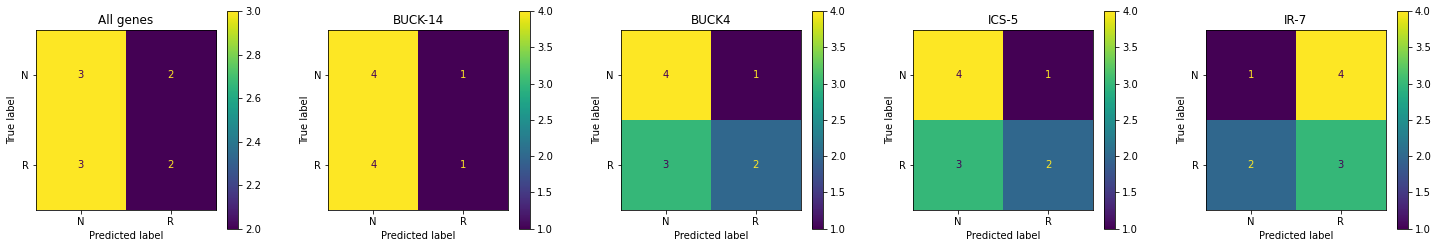

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.3)

for name, genes in gene_list.items():

  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]

  # train the model
  rfc = RandomForestClassifier()
  rfc = rfc.fit(condition1_data[train_samp].T, train_labels)

  # predict class labels for the testing set
  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)
  
  disp = plot_confusion_matrix(rfc, condition1_data[test_samp].T, test_labels, ax=ax[count])
  disp.ax_.set_title(name)

  cm = confusion_matrix(test_labels, rfc_predictions)
  confusion = pd.DataFrame(cm, 
                          index=['True: N', 'True: R'], 
                          columns=['Pred: N', 'Pred: R'])

  confusion.loc['Total'] = confusion.sum()
  confusion['Total'] = confusion.sum(axis = 1)
  
  performance_res = pd.Series(dtype = float,
                            index = ['Accuracy', 'Sensitivity', 
                                     'Specificity', 'Precision',
                                    'F1 Score', 'MCC'])

  # get the needed values
  tp = confusion.loc['True: R', 'Pred: R']
  tn = confusion.loc['True: N', 'Pred: N']
  fp = confusion.loc['True: N', 'Pred: R']
  fn = confusion.loc['True: R', 'Pred: N']
  all_ = confusion.loc['Total', 'Total']

  # compute statistics
  performance_res['Accuracy'] = (tp + tn)/all_
  performance_res['Sensitivity'] = tp/(tp + fn)
  performance_res['Specificity'] = tn/(tn + fp)
  performance_res['Precision'] = tp/(tp + fp)
  performance_res['F1 Score'] = tp/(tp + 0.5*(fp+fn))
  performance_res['MCC'] = metrics.matthews_corrcoef(test_labels, rfc_predictions)

  # display
  print(name, 'Random Forest HR-')
  display(performance_res)
  print('\n')
  
  count+=1

plt.show()


## 3x3 Heatmaps

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


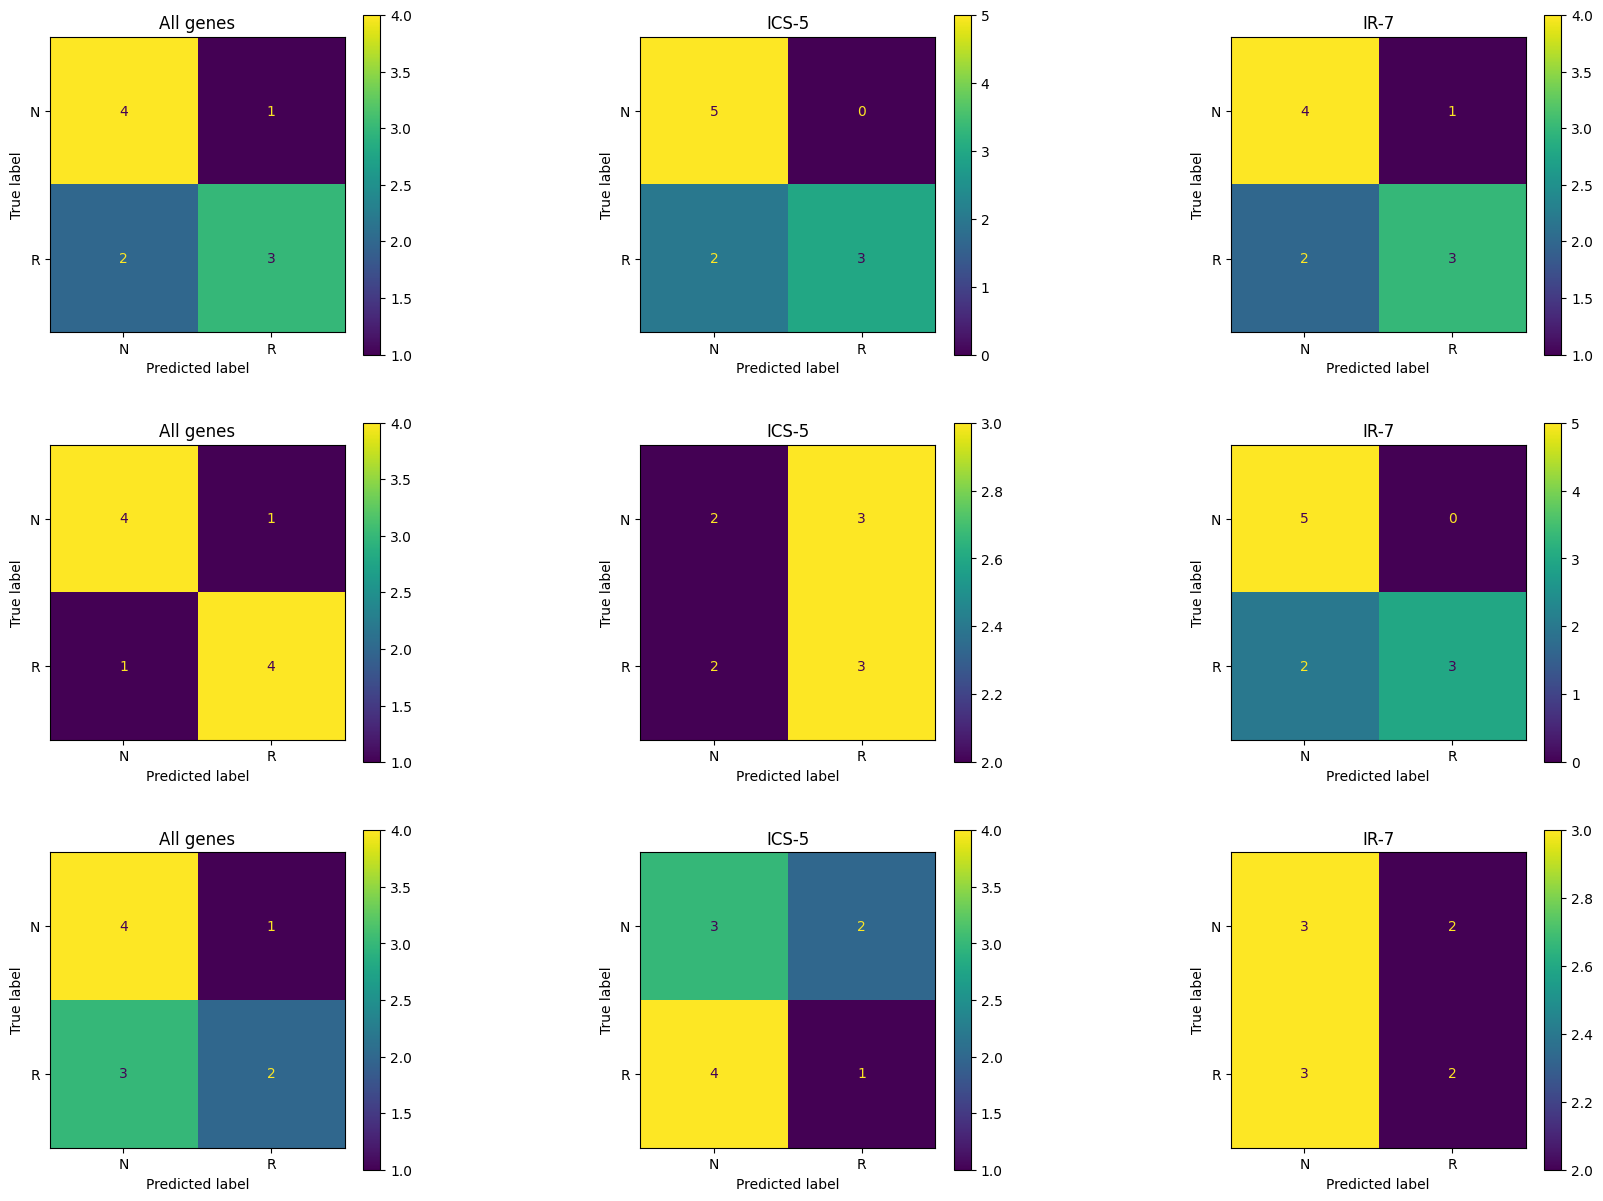

In [ ]:
# set up plots
fig, ax = plt.subplots(3, 3, figsize = (20, 15))
plt.subplots_adjust(wspace = 0.6)

gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

ax_num = {'All genes':0, 'ICS-5':1, 'IR-7':2, 'lr':0, 'sv':1, 'rfc':2}

count = 0

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  
  for name_c, predict in {'lr':lr, 'sv':sv, 'rfc':rfc}.items():

    disp = plot_confusion_matrix(predict, condition1_data[test_samp].T, test_labels, ax=ax[ax_num[name_c], count])
    disp.ax_.set_title(name)
    
  count += 1

#plt.legend()
plt.show()

## PR Curve Plots

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


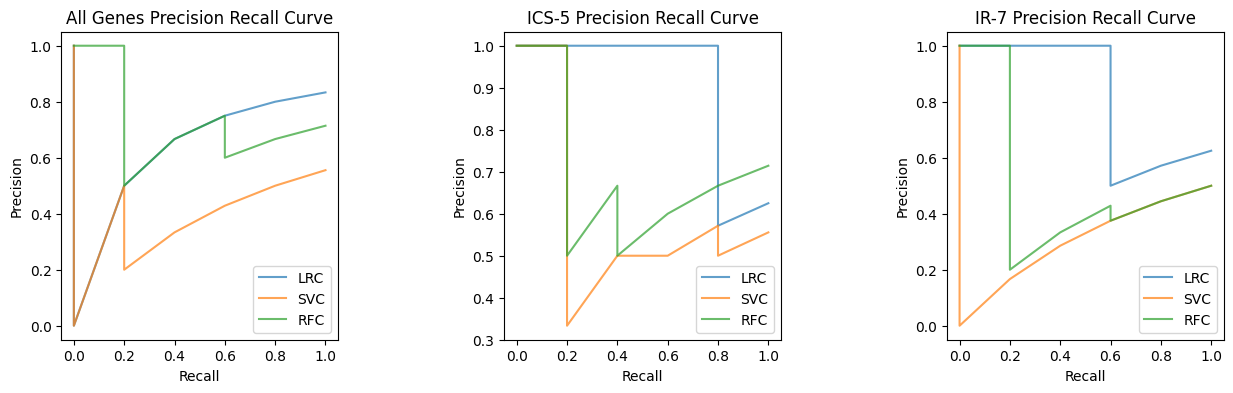

In [ ]:
gene_list = {'All Genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

# set up plots
fig, ax = plt.subplots(1, len(gene_list), figsize = (15, 4))
plt.subplots_adjust(wspace = 0.6)


count = 0

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.recur[train_samp]
  test_labels = HR_samp.recur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  # get the log probabilities
  proba_lr = lr.predict_proba(condition1_data[test_samp].T)
  proba_sv = sv.predict_proba(condition1_data[test_samp].T)
  proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

  # add labels
  proba_lr = pd.DataFrame(proba_lr, index = test_samp,
                          columns = lr.classes_)
  
  proba_sv = pd.DataFrame(proba_sv, index = test_samp,
                          columns = sv.classes_)
  
  proba_rfc = pd.DataFrame(proba_rfc, index = test_samp,
                          columns = rfc.classes_)

  # pull out the column associated with positive
  proba_lr = proba_lr[True]
  proba_sv = proba_sv[True]
  proba_rfc = proba_rfc[True]


  for proba_c in [proba_lr, proba_sv, proba_rfc]:

    # get the PR curve data
    prec, rec, pr_thresh = metrics.precision_recall_curve(test_labels,
                              proba_c)
    
    ax[count].plot(rec, prec, alpha=0.7)
    ax[count].set_xlabel('Recall')
    ax[count].set_ylabel('Precision')
    ax[count].set_title('%s Precision Recall Curve'%name)
    ax[count].legend(["LRC", "SVC", 'RFC'], loc ="lower right")

  count += 1


plt.show()

## ROC Plots

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}


# set up plots
fig, ax = plt.subplots(1, len(gene_list), figsize = (15, 4))
plt.subplots_adjust(wspace = 0.6)


count = 0
auc_values = {'All genes':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK-14':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK4':{'lr':0, 'sv':0, 'rfc':0}, 
         'ICS-5':{'lr':0, 'sv':0, 'rfc':0},
         'IR-7':{'lr':0, 'sv':0, 'rfc':0}}

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.nonrecur[train_samp]
  test_labels = HR_samp.nonrecur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  # get the log probabilities
  proba_lr = lr.predict_proba(condition1_data[test_samp].T)
  proba_sv = sv.predict_proba(condition1_data[test_samp].T)
  proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

  # add labels
  #proba_lr = pd.DataFrame(proba_lr, index = test_samp,
  #                        columns = lr.classes_)
  
  #proba_sv = pd.DataFrame(proba_sv, index = test_samp,
  #                        columns = sv.classes_)
  
  #proba_rfc = pd.DataFrame(proba_rfc, index = test_samp,
  #                        columns = rfc.classes_)

  # pull out the column associated with positive
  #proba_lr = proba_lr[True]
  #proba_sv = proba_sv[True]
  #proba_rfc = proba_rfc[True]

  for name_c, proba_c in {'lr':proba_lr, 'sv':proba_sv, 'rfc':proba_rfc}.items():

    # get the ROC data
    fpr, tpr, roc_thresh = metrics.roc_curve(test_labels, proba_c[:,1])
    print(name_c, fpr, tpr)

    # get the AUC
    roc_auc = metrics.auc(fpr, tpr)

    auc_values[name][name_c] = roc_auc
    
    # plot the ROC curve
    ax[count].step(fpr, tpr, alpha=0.7)
    ax[count].set_xlabel('False Positive Rate')
    ax[count].set_ylabel('True Positive Rate')
    ax[count].set_title('%s ROC Curve'%(name))
    ax[count].legend(["LRC (AUC = %.2f)"%(auc_values[name]['lr']), "SVC (AUC = %.2f)"%(auc_values[name]['sv']), "RFC (AUC = %.2f)"%(auc_values[name]['rfc'])], loc ="best")

  count += 1

#plt.legend()
plt.show()

plot_confusion_matrix(sv, condition1_data[test_samp].T, test_labels)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


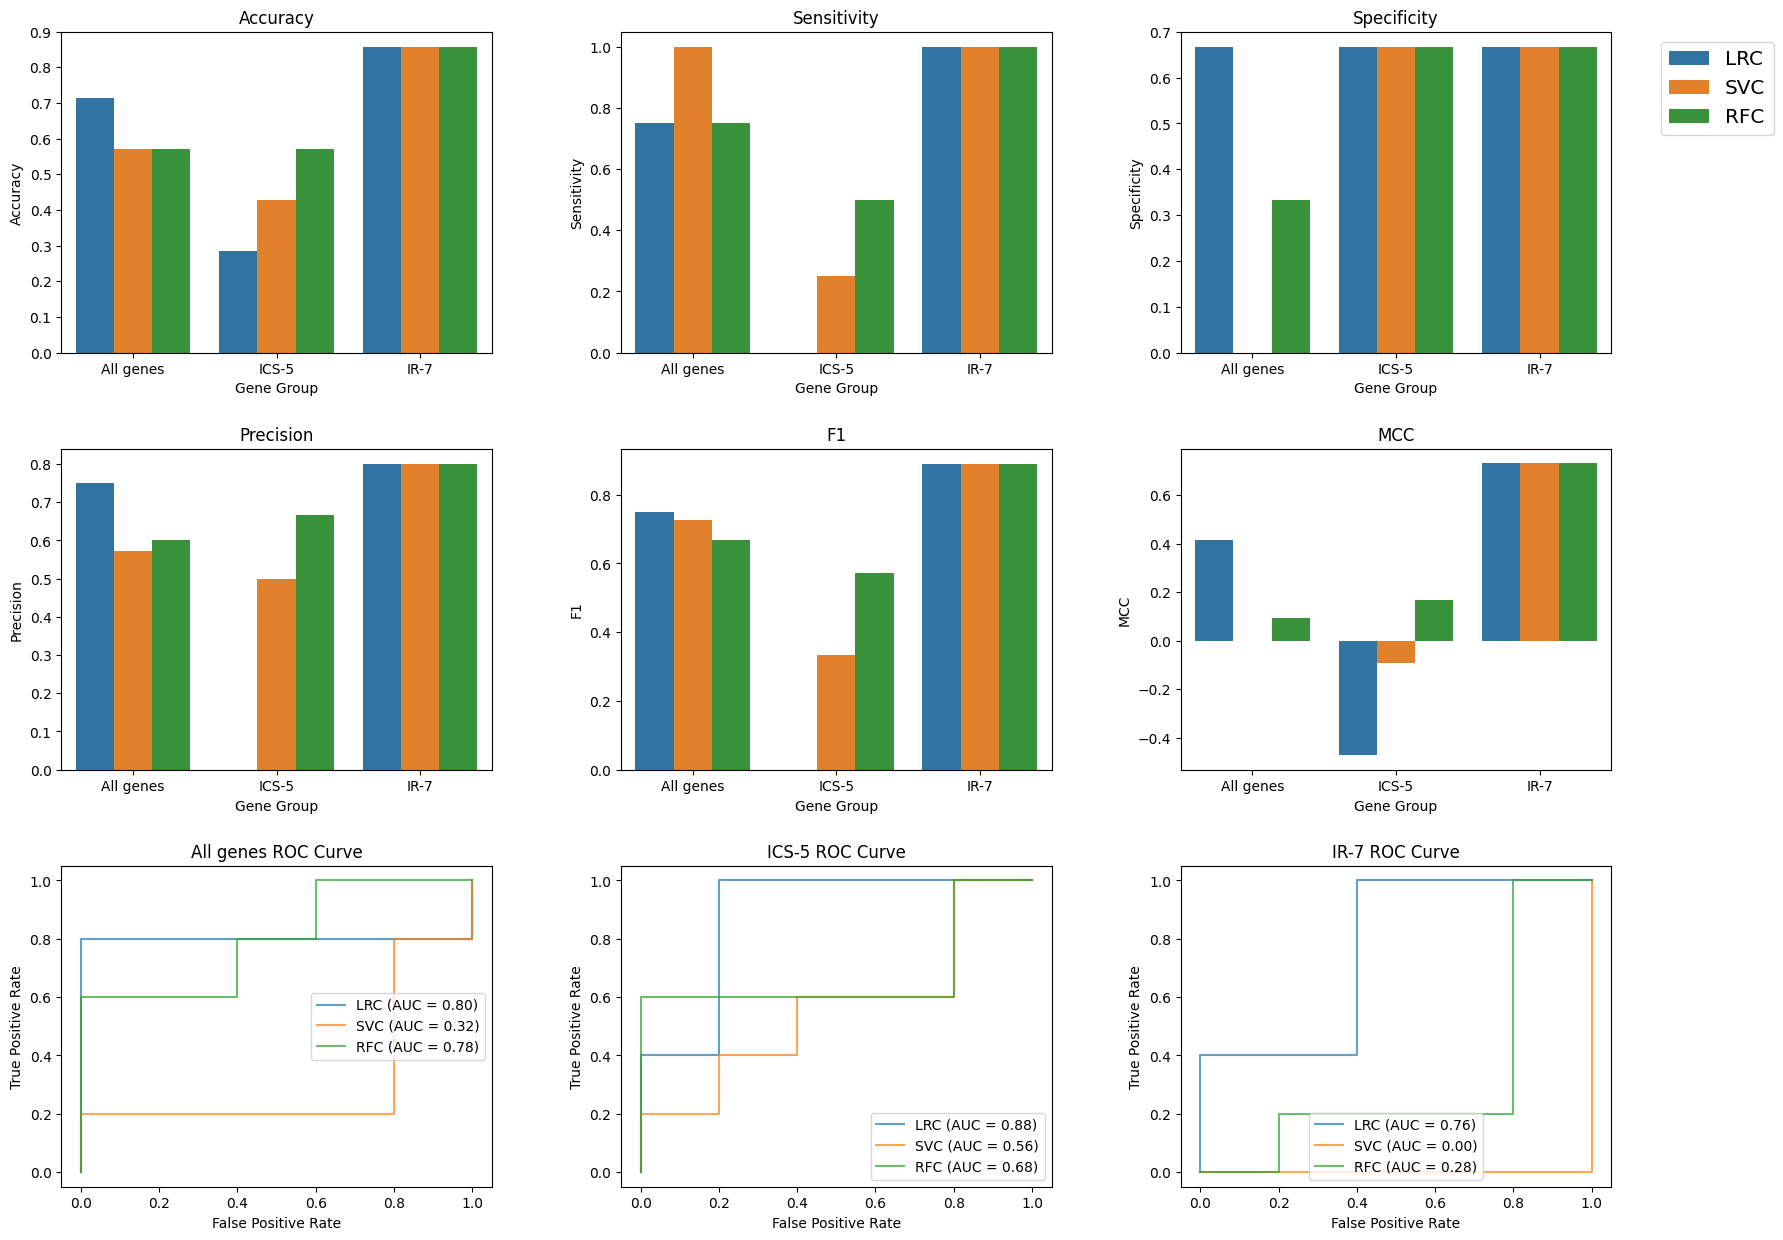

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}


# set up plots
fig, ax = plt.subplots(3, len(gene_list), figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace=0.3)


count = 0
auc_values = {'All genes':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK-14':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK4':{'lr':0, 'sv':0, 'rfc':0}, 
         'ICS-5':{'lr':0, 'sv':0, 'rfc':0},
         'IR-7':{'lr':0, 'sv':0, 'rfc':0}}

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.nonrecur[train_samp]
  test_labels = HR_samp.nonrecur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  # get the log probabilities
  proba_lr = lr.predict_proba(condition1_data[test_samp].T)
  proba_sv = sv.predict_proba(condition1_data[test_samp].T)
  proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

  # add labels
  #proba_lr = pd.DataFrame(proba_lr, index = test_samp,
  #                        columns = lr.classes_)
  
  #proba_sv = pd.DataFrame(proba_sv, index = test_samp,
  #                        columns = sv.classes_)
  
  #proba_rfc = pd.DataFrame(proba_rfc, index = test_samp,
  #                        columns = rfc.classes_)

  # pull out the column associated with positive
  #proba_lr = proba_lr[True]
  #proba_sv = proba_sv[True]
  #proba_rfc = proba_rfc[True]

  for name_c, proba_c in {'lr':proba_lr, 'sv':proba_sv, 'rfc':proba_rfc}.items():

    # get the ROC data
    fpr, tpr, roc_thresh = metrics.roc_curve(test_labels, proba_c[:,1])
    #print(name_c, fpr, tpr)

    # get the AUC
    roc_auc = metrics.auc(fpr, tpr)

    auc_values[name][name_c] = roc_auc
    
    # plot the ROC curve
    ax[2, count].step(fpr, tpr, alpha=0.7)
    ax[2, count].set_xlabel('False Positive Rate')
    ax[2, count].set_ylabel('True Positive Rate')
    ax[2, count].set_title('%s ROC Curve'%(name))
    ax[2,count].legend(["LRC (AUC = %.2f)"%(auc_values[name]['lr']), "SVC (AUC = %.2f)"%(auc_values[name]['sv']), "RFC (AUC = %.2f)"%(auc_values[name]['rfc'])], loc ="best")

  count += 1

  for name_c, pred in {'LRC':lr_predictions, 'SVC':sv_predictions, 'RFC':rfc_predictions}.items():

    cm = confusion_matrix(test_labels, pred)
    confusion = pd.DataFrame(cm, 
                            index=['True: N', 'True: R'], 
                            columns=['Pred: N', 'Pred: R'])

    confusion.loc['Total'] = confusion.sum()
    confusion['Total'] = confusion.sum(axis = 1)

    # get the needed values
    tp = confusion.loc['True: R', 'Pred: R']
    tn = confusion.loc['True: N', 'Pred: N']
    fp = confusion.loc['True: N', 'Pred: R']
    fn = confusion.loc['True: R', 'Pred: N']
    all_ = confusion.loc['Total', 'Total']

    accuracy = (tp + tn)/all_
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    precision = tp/(tp + fp)
    f1 = tp/(tp + 0.5*(fp+fn))
    mcc = metrics.matthews_corrcoef(test_labels, pred)

    score_list.append([accuracy, sensitivity, specificity, precision, f1, mcc, name, name_c])



# Accuracy
sns.barplot(x='Gene Group', y='Accuracy', hue='Classifier', data=score_df, ax=ax[0, 0])
ax[0, 0].set_title('Accuracy')


# Sensitivity
sns.barplot(x='Gene Group', y='Sensitivity', hue='Classifier', data=score_df, ax=ax[0, 1])
ax[0, 1].set_title('Sensitivity')

# Specificity
sns.barplot(x='Gene Group', y='Specificity', hue='Classifier', data=score_df, ax=ax[0, 2])
ax[0, 2].set_title('Specificity')

# Precision
sns.barplot(x='Gene Group', y='Precision', hue='Classifier', data=score_df, ax=ax[1,0])
ax[1, 0].set_title('Precision')


# F1
sns.barplot(x='Gene Group', y='F1', hue='Classifier', data=score_df, ax=ax[1,1])
ax[1, 1].set_title('F1')

# MCC
sns.barplot(x='Gene Group', y='MCC', hue='Classifier', data=score_df, ax=ax[1,2])
ax[1, 2].set_title('MCC')

# get the log probabilities
proba_lr = lr.predict_proba(condition1_data[test_samp].T)
proba_sv = sv.predict_proba(condition1_data[test_samp].T)
proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

ax[0,0].legend([],[], frameon=False)
ax[0,1].legend([],[], frameon=False)
ax[0,2].legend(bbox_to_anchor=(1.4, 1), loc=1, fontsize='x-large')

ax[1,0].legend([],[], frameon=False)
ax[1,1].legend([],[], frameon=False)
ax[1,2].legend([],[], frameon=False)



#plt.legend(bbox_to_anchor=(1.05,2), loc=2)
plt.show()

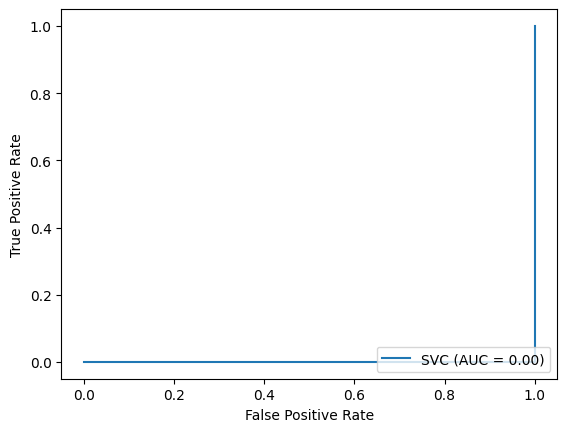

In [ ]:
svc_disp = metrics.plot_roc_curve(sv, condition1_data[test_samp].T, test_labels)
plt.show()

In [ ]:
test_labels

Sample ID
C2      True
C14     True
C16     True
C18     True
C25     True
C38    False
C51    False
C67    False
C71    False
C79    False
Name: recur, dtype: bool

In [ ]:
proba_sv

C2     0.522195
C14    0.377462
C16    0.432780
C18    0.363229
C25    0.487217
C38    0.581674
C51    0.563633
C67    0.567146
C71    0.541913
C79    0.543741
Name: True, dtype: float64

In [ ]:
proba_lr

C2     0.441681
C14    0.542307
C16    0.536654
C18    0.593443
C25    0.441861
C38    0.434888
C51    0.459893
C67    0.341170
C71    0.486935
C79    0.512755
Name: True, dtype: float64

In [ ]:
auc_values

{'All genes': {'lr': 0.8, 'rfc': 0.64, 'sv': 0.31999999999999995},
 'BUCK-14': {'lr': 0.74, 'rfc': 0.8800000000000001, 'sv': 0.19999999999999996},
 'BUCK4': {'lr': 0.76, 'rfc': 0.6799999999999999, 'sv': 0.2},
 'ICS-5': {'lr': 0.88, 'rfc': 0.76, 'sv': 0.5599999999999999},
 'IR-7': {'lr': 0.76, 'rfc': 0.21999999999999997, 'sv': 0.0}}

## Scoring Plots

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


No handles with labels found to put in legend.


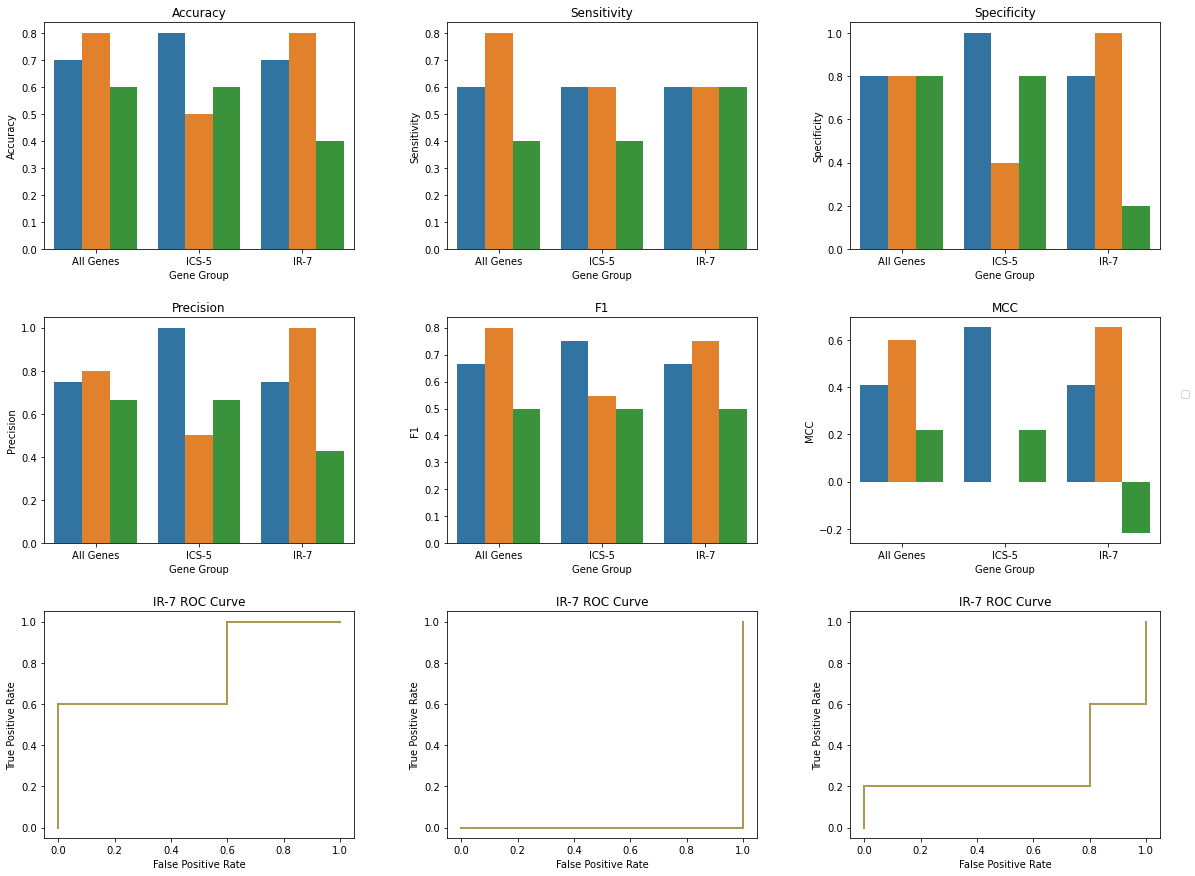

In [ ]:
gene_list = {'All Genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}



auc_values = {'All Genes':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK-14':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK4':{'lr':0, 'sv':0, 'rfc':0}, 
         'ICS-5':{'lr':0, 'sv':0, 'rfc':0},
         'IR-7':{'lr':0, 'sv':0, 'rfc':0}}

# set up plots
fig, ax = plt.subplots(3, 3, figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

score_list = []

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.recur[train_samp]
  test_labels = HR_samp.recur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)

  #auc_values = {'lr':0, 'sv':0, 'rfc':0}
  for name_c, pred in {'LRC':lr_predictions, 'SVC':sv_predictions, 'RFC':rfc_predictions}.items():

    cm = confusion_matrix(test_labels, pred)
    confusion = pd.DataFrame(cm, 
                            index=['True: N', 'True: R'], 
                            columns=['Pred: N', 'Pred: R'])

    confusion.loc['Total'] = confusion.sum()
    confusion['Total'] = confusion.sum(axis = 1)

    # get the needed values
    tp = confusion.loc['True: R', 'Pred: R']
    tn = confusion.loc['True: N', 'Pred: N']
    fp = confusion.loc['True: N', 'Pred: R']
    fn = confusion.loc['True: R', 'Pred: N']
    all_ = confusion.loc['Total', 'Total']

    accuracy = (tp + tn)/all_
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    precision = tp/(tp + fp)
    f1 = tp/(tp + 0.5*(fp+fn))
    mcc = metrics.matthews_corrcoef(test_labels, pred)

    score_list.append([accuracy, sensitivity, specificity, precision, f1, mcc, name, name_c])

    count = 0
    for name_c, proba_c in {'lr':proba_lr, 'sv':proba_sv, 'rfc':proba_rfc}.items():

      # get the ROC data
      fpr, tpr, roc_thresh = metrics.roc_curve(test_labels, proba_c[:,1])
      #print(name_c, fpr, tpr)

      # get the AUC
      roc_auc = metrics.auc(fpr, tpr)

      auc_values[name][name_c] = roc_auc
      
      # plot the ROC curve
      print(count)
      ax[2, count].step(fpr, tpr, alpha=0.7)
      ax[2, count].set_xlabel('False Positive Rate')
      ax[2, count].set_ylabel('True Positive Rate')
      ax[2, count].set_title('%s ROC Curve'%(name))
      ax[2, count].legend(["LRC (AUC = %.2f)"%(auc_values[name]['lr']), "SVC (AUC = %.2f)"%(auc_values[name]['sv']), "RFC (AUC = %.2f)"%(auc_values[name]['rfc'])], loc ="best")

      count += 1

# Dataframe of scores
score_df = pd.DataFrame(score_list, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'MCC', 'Gene Group', 'Classifier'])

# # Accuracy
# ax = sns.barplot(x='Gene Group', y='Accuracy', hue='Classifier', data=score_df)
# plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.title('Accuracy')
# plt.show()

# # Sensitivity
# ax = sns.barplot(x='Gene Group', y='Sensitivity', hue='Classifier', data=score_df)
# plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.title('Sensitivity')
# plt.show()

# # Specificity
# ax = sns.barplot(x='Gene Group', y='Specificity', hue='Classifier', data=score_df)
# plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.title('Specificity')
# plt.show()

# # Precision
# ax = sns.barplot(x='Gene Group', y='Precision', hue='Classifier', data=score_df)
# plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.title('Precision')
# plt.show()

# # F1 Score
# ax = sns.barplot(x='Gene Group', y='F1', hue='Classifier', data=score_df)
# plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.title('F1 Score')
# plt.show()

# # MCC
# ax = sns.barplot(x='Gene Group', y='MCC', hue='Classifier', data=score_df)
# plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.title('Matthews Correlation Coefficient')
# plt.show()




# Accuracy
sns.barplot(x='Gene Group', y='Accuracy', hue='Classifier', data=score_df, ax=ax[0, 0])
ax[0, 0].set_title('Accuracy')


# Sensitivity
sns.barplot(x='Gene Group', y='Sensitivity', hue='Classifier', data=score_df, ax=ax[0, 1])
ax[0, 1].set_title('Sensitivity')

# Specificity
sns.barplot(x='Gene Group', y='Specificity', hue='Classifier', data=score_df, ax=ax[0, 2])
ax[0, 2].set_title('Specificity')

# Precision
sns.barplot(x='Gene Group', y='Precision', hue='Classifier', data=score_df, ax=ax[1,0])
ax[1, 0].set_title('Precision')


# F1
sns.barplot(x='Gene Group', y='F1', hue='Classifier', data=score_df, ax=ax[1,1])
ax[1, 1].set_title('F1')

# MCC
sns.barplot(x='Gene Group', y='MCC', hue='Classifier', data=score_df, ax=ax[1,2])
ax[1, 2].set_title('MCC')

# get the log probabilities
proba_lr = lr.predict_proba(condition1_data[test_samp].T)
proba_sv = sv.predict_proba(condition1_data[test_samp].T)
proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

for a in ax:
    a[0].legend([],[], frameon=False)
    a[1].legend([],[], frameon=False)
    a[2].legend([],[], frameon=False)



plt.legend(bbox_to_anchor=(1.05,2), loc=2)
plt.show()

# Results Triple Negative

## Logistic Regression Heatmaps

All genes Logistic Regression Triple Negative


Accuracy       0.714286
Sensitivity    0.666667
Specificity    0.750000
Precision      0.666667
F1 Score       0.666667
MCC            0.416667
dtype: float64



BUCK-14 Logistic Regression Triple Negative


Accuracy       0.571429
Sensitivity    0.333333
Specificity    0.750000
Precision      0.500000
F1 Score       0.400000
MCC            0.091287
dtype: float64



BUCK4 Logistic Regression Triple Negative


Accuracy       0.428571
Sensitivity    0.333333
Specificity    0.500000
Precision      0.333333
F1 Score       0.333333
MCC           -0.166667
dtype: float64



ICS-5 Logistic Regression Triple Negative


Accuracy       0.285714
Sensitivity    0.666667
Specificity    0.000000
Precision      0.333333
F1 Score       0.444444
MCC           -0.471405
dtype: float64



IR-7 Logistic Regression Triple Negative


Accuracy       0.857143
Sensitivity    0.666667
Specificity    1.000000
Precision      1.000000
F1 Score       0.800000
MCC            0.730297
dtype: float64

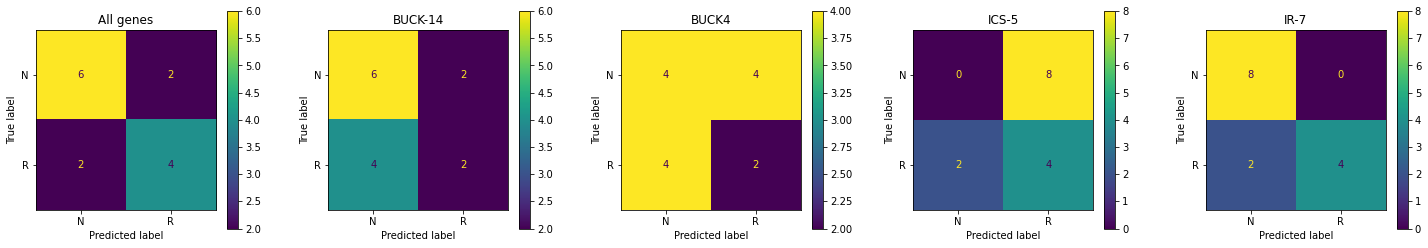

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.3)


for name, genes in gene_list.items():

  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_B_train, R_B_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  R_N_train, R_N_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] != 'HER2'], random_state=0)
  N_B_train, N_B_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  N_N_train, N_N_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] != 'HER2'], random_state=0)

  #print(R_N_train, R_N_test)

  # get samples
  train_samp = list(R_B_train) + list(R_N_train) + list(N_B_train) + list(N_N_train)
  test_samp = list(R_B_test) + list(R_N_test) + list(N_B_test) + list(N_N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]

  # train the model
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)

  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)
  
  disp = plot_confusion_matrix(lr, condition1_data[test_samp].T, test_labels, ax=ax[count])
  disp.ax_.set_title(name)

  #print(name)
  #print(disp.confusion_matrix)

  cm = confusion_matrix(test_labels, lr_predictions)
  confusion = pd.DataFrame(cm, 
                          index=['True: N', 'True: R'], 
                          columns=['Pred: N', 'Pred: R'])

  confusion.loc['Total'] = confusion.sum()
  confusion['Total'] = confusion.sum(axis = 1)
  
  performance_res = pd.Series(dtype = float,
                            index = ['Accuracy', 'Sensitivity', 
                                     'Specificity', 'Precision',
                                    'F1 Score', 'MCC'])

  # get the needed values
  tp = confusion.loc['True: R', 'Pred: R']
  tn = confusion.loc['True: N', 'Pred: N']
  fp = confusion.loc['True: N', 'Pred: R']
  fn = confusion.loc['True: R', 'Pred: N']
  all_ = confusion.loc['Total', 'Total']

  # compute statistics
  performance_res['Accuracy'] = (tp + tn)/all_
  performance_res['Sensitivity'] = tp/(tp + fn)
  performance_res['Specificity'] = tn/(tn + fp)
  performance_res['Precision'] = tp/(tp + fp)
  performance_res['F1 Score'] = tp/(tp + 0.5*(fp+fn))
  performance_res['MCC'] = metrics.matthews_corrcoef(test_labels, lr_predictions)

  # display
  print(name, 'Logistic Regression Triple Negative')
  display(performance_res)
  print('\n')

  count+=1

plt.show()


## SVC Heatmaps

All genes SVC HR-


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Accuracy       0.857143
Sensitivity    0.666667
Specificity    1.000000
Precision      1.000000
F1 Score       0.800000
MCC            0.000000
dtype: float64



BUCK-14 SVC HR-


Accuracy       0.857143
Sensitivity    0.666667
Specificity    1.000000
Precision      1.000000
F1 Score       0.800000
MCC            0.091287
dtype: float64



BUCK4 SVC HR-


Accuracy       0.857143
Sensitivity    0.666667
Specificity    1.000000
Precision      1.000000
F1 Score       0.800000
MCC           -0.166667
dtype: float64



ICS-5 SVC HR-


Accuracy       0.857143
Sensitivity    0.666667
Specificity    1.000000
Precision      1.000000
F1 Score       0.800000
MCC           -0.091287
dtype: float64



IR-7 SVC HR-


Accuracy       0.857143
Sensitivity    0.666667
Specificity    1.000000
Precision      1.000000
F1 Score       0.800000
MCC            0.730297
dtype: float64

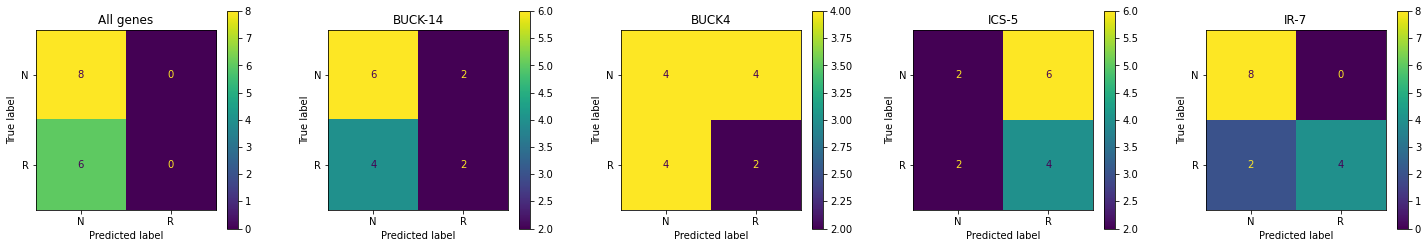

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.3)

for name, genes in gene_list.items():

  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_B_train, R_B_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  R_N_train, R_N_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] != 'HER2'], random_state=0)
  N_B_train, N_B_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  N_N_train, N_N_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] != 'HER2'], random_state=0)

  # get samples
  train_samp = list(R_B_train) + list(R_N_train) + list(N_B_train) + list(N_N_train)
  test_samp = list(R_B_test) + list(R_N_test) + list(N_B_test) + list(N_N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]

  # train the model
  svc_model = SVC(kernel = 'linear', probability=True)
  svc_model_rbf = SVC(kernel = 'rbf', gamma='scale', probability=True)
  sv = svc_model.fit(condition1_data[train_samp].T, train_labels)
  sv_rbf = svc_model_rbf.fit(condition1_data[train_samp].T, train_labels)

  # predict class labels for the testing set
  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)
  sv_predictions_rbf = sv_rbf.predict(condition1_data[test_samp].T)
  sv_predictions_rbf = pd.Series(sv_predictions_rbf, index = test_samp)
  
  disp = plot_confusion_matrix(sv, condition1_data[test_samp].T, test_labels, ax=ax[count])
  disp.ax_.set_title(name)

  cm = confusion_matrix(test_labels, lr_predictions)
  confusion = pd.DataFrame(cm, 
                          index=['True: N', 'True: R'], 
                          columns=['Pred: N', 'Pred: R'])

  confusion.loc['Total'] = confusion.sum()
  confusion['Total'] = confusion.sum(axis = 1)
  
  performance_res = pd.Series(dtype = float,
                            index = ['Accuracy', 'Sensitivity', 
                                     'Specificity', 'Precision',
                                    'F1 Score', 'MCC'])

  # get the needed values
  tp = confusion.loc['True: R', 'Pred: R']
  tn = confusion.loc['True: N', 'Pred: N']
  fp = confusion.loc['True: N', 'Pred: R']
  fn = confusion.loc['True: R', 'Pred: N']
  all_ = confusion.loc['Total', 'Total']

  # compute statistics
  performance_res['Accuracy'] = (tp + tn)/all_
  performance_res['Sensitivity'] = tp/(tp + fn)
  performance_res['Specificity'] = tn/(tn + fp)
  performance_res['Precision'] = tp/(tp + fp)
  performance_res['F1 Score'] = tp/(tp + 0.5*(fp+fn))
  performance_res['MCC'] = metrics.matthews_corrcoef(test_labels, sv_predictions)

  # display
  print(name, 'SVC HR-')
  display(performance_res)
  print('\n')

  count+=1
  

plt.show()


## Random Forest Heatmaps

All genes Random Forest HR-


Accuracy       0.428571
Sensitivity    0.000000
Specificity    0.750000
Precision      0.000000
F1 Score       0.000000
MCC           -0.353553
dtype: float64



BUCK-14 Random Forest HR-


Accuracy       0.571429
Sensitivity    0.333333
Specificity    0.750000
Precision      0.500000
F1 Score       0.400000
MCC            0.091287
dtype: float64



BUCK4 Random Forest HR-


Accuracy       0.571429
Sensitivity    0.666667
Specificity    0.500000
Precision      0.500000
F1 Score       0.571429
MCC            0.166667
dtype: float64



ICS-5 Random Forest HR-


Accuracy       0.428571
Sensitivity    0.666667
Specificity    0.250000
Precision      0.400000
F1 Score       0.500000
MCC           -0.091287
dtype: float64



IR-7 Random Forest HR-


Accuracy       0.714286
Sensitivity    0.666667
Specificity    0.750000
Precision      0.666667
F1 Score       0.666667
MCC            0.416667
dtype: float64

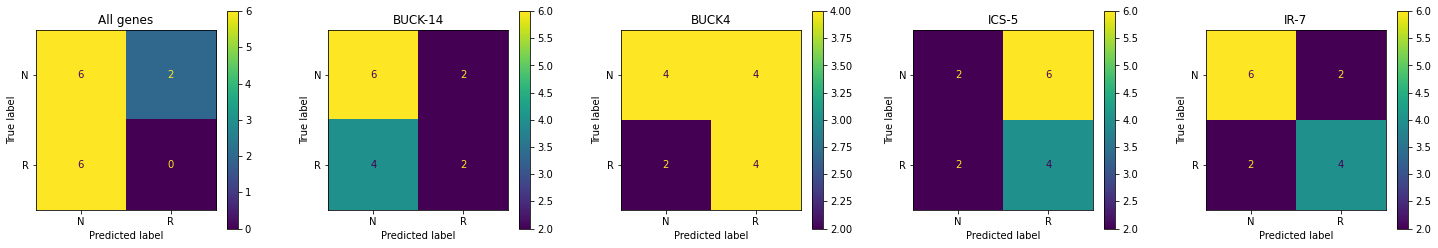

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

fig, ax = plt.subplots(1, 5, figsize = (25, 4))
plt.subplots_adjust(wspace = 0.3)

for name, genes in gene_list.items():

  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_B_train, R_B_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  R_N_train, R_N_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] != 'HER2'], random_state=0)
  N_B_train, N_B_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  N_N_train, N_N_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] != 'HER2'], random_state=0)

  # get samples
  train_samp = list(R_B_train) + list(R_N_train) + list(N_B_train) + list(N_N_train)
  test_samp = list(R_B_test) + list(R_N_test) + list(N_B_test) + list(N_N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]

  # train the model
  rfc = RandomForestClassifier()
  rfc = rfc.fit(condition1_data[train_samp].T, train_labels)

  # predict class labels for the testing set
  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)
  
  disp = plot_confusion_matrix(rfc, condition1_data[test_samp].T, test_labels, ax=ax[count])
  disp.ax_.set_title(name)

  cm = confusion_matrix(test_labels, rfc_predictions)
  confusion = pd.DataFrame(cm, 
                          index=['True: N', 'True: R'], 
                          columns=['Pred: N', 'Pred: R'])

  confusion.loc['Total'] = confusion.sum()
  confusion['Total'] = confusion.sum(axis = 1)
  
  performance_res = pd.Series(dtype = float,
                            index = ['Accuracy', 'Sensitivity', 
                                     'Specificity', 'Precision',
                                    'F1 Score', 'MCC'])

  # get the needed values
  tp = confusion.loc['True: R', 'Pred: R']
  tn = confusion.loc['True: N', 'Pred: N']
  fp = confusion.loc['True: N', 'Pred: R']
  fn = confusion.loc['True: R', 'Pred: N']
  all_ = confusion.loc['Total', 'Total']

  # compute statistics
  performance_res['Accuracy'] = (tp + tn)/all_
  performance_res['Sensitivity'] = tp/(tp + fn)
  performance_res['Specificity'] = tn/(tn + fp)
  performance_res['Precision'] = tp/(tp + fp)
  performance_res['F1 Score'] = tp/(tp + 0.5*(fp+fn))
  performance_res['MCC'] = metrics.matthews_corrcoef(test_labels, rfc_predictions)

  # display
  print(name, 'Random Forest HR-')
  display(performance_res)
  print('\n')

  count+=1
  

plt.show()


## 3x3 Heatmaps

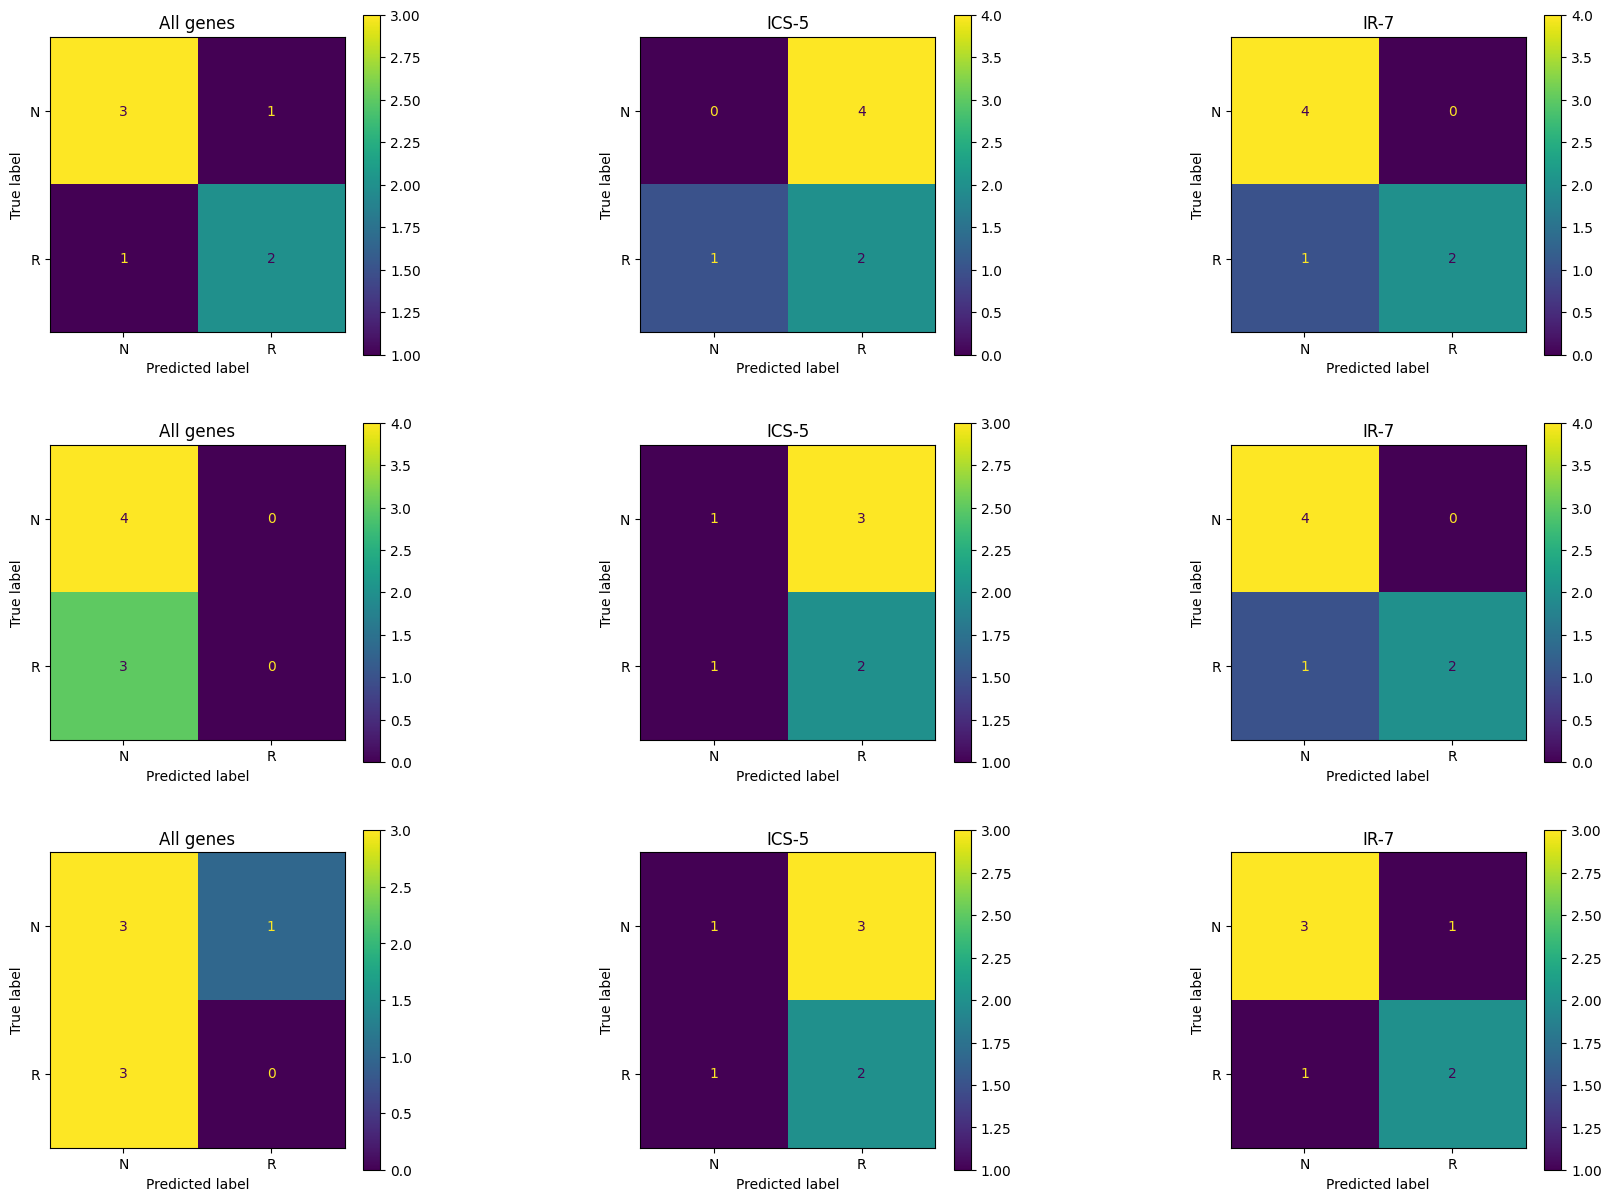

In [ ]:
# set up plots
fig, ax = plt.subplots(3, 3, figsize = (20, 15))
plt.subplots_adjust(wspace = 0.6)

gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

ax_num = {'All genes':0, 'ICS-5':1, 'IR-7':2, 'lr':0, 'sv':1, 'rfc':2}

count = 0

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Cancer Subtype'] == 'Triple Negative']

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.Recurrence[train_samp]
  test_labels = HR_samp.Recurrence[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  
  for name_c, predict in {'lr':lr, 'sv':sv, 'rfc':rfc}.items():

    disp = plot_confusion_matrix(predict, condition1_data[test_samp].T, test_labels, ax=ax[ax_num[name_c], count])
    disp.ax_.set_title(name)
    
  count += 1

#plt.legend()
plt.show()

## Precision Recall Curves

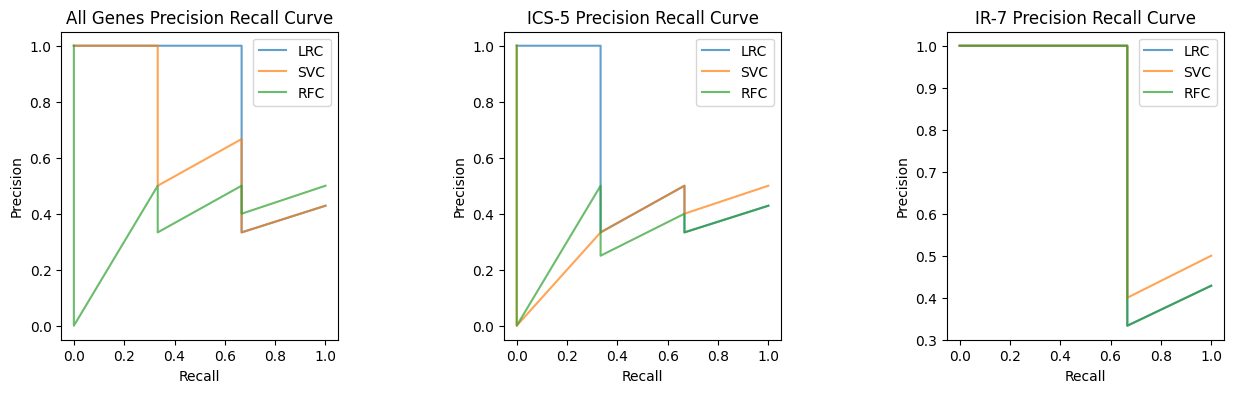

In [ ]:
gene_list = {'All Genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

# set up plots
fig, ax = plt.subplots(1, len(gene_list), figsize = (15, 4))
plt.subplots_adjust(wspace = 0.6)


count = 0

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_B_train, R_B_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  R_N_train, R_N_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] != 'HER2'], random_state=0)
  N_B_train, N_B_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  N_N_train, N_N_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] != 'HER2'], random_state=0)

  # get samples
  train_samp = list(R_B_train) + list(R_N_train) + list(N_B_train) + list(N_N_train)
  test_samp = list(R_B_test) + list(R_N_test) + list(N_B_test) + list(N_N_test)
  
  # get labels
  train_labels = HR_samp.recur[train_samp]
  test_labels = HR_samp.recur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  # get the log probabilities
  proba_lr = lr.predict_proba(condition1_data[test_samp].T)
  proba_sv = sv.predict_proba(condition1_data[test_samp].T)
  proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

  # add labels
  proba_lr = pd.DataFrame(proba_lr, index = test_samp,
                          columns = lr.classes_)
  
  proba_sv = pd.DataFrame(proba_sv, index = test_samp,
                          columns = sv.classes_)
  
  proba_rfc = pd.DataFrame(proba_rfc, index = test_samp,
                          columns = rfc.classes_)

  # pull out the column associated with positive
  proba_lr = proba_lr[True]
  proba_sv = proba_sv[True]
  proba_rfc = proba_rfc[True]


  for proba_c in [proba_lr, proba_sv, proba_rfc]:

    # get the PR curve data
    prec, rec, pr_thresh = metrics.precision_recall_curve(test_labels,
                              proba_c)
    
    ax[count].plot(rec, prec, alpha=0.7)
    ax[count].set_xlabel('Recall')
    ax[count].set_ylabel('Precision')
    ax[count].set_title('%s Precision Recall Curve'%name)
    ax[count].legend(["LRC", "SVC", 'RFC'], loc ="upper right")

  count += 1


plt.show()

## ROC Curve

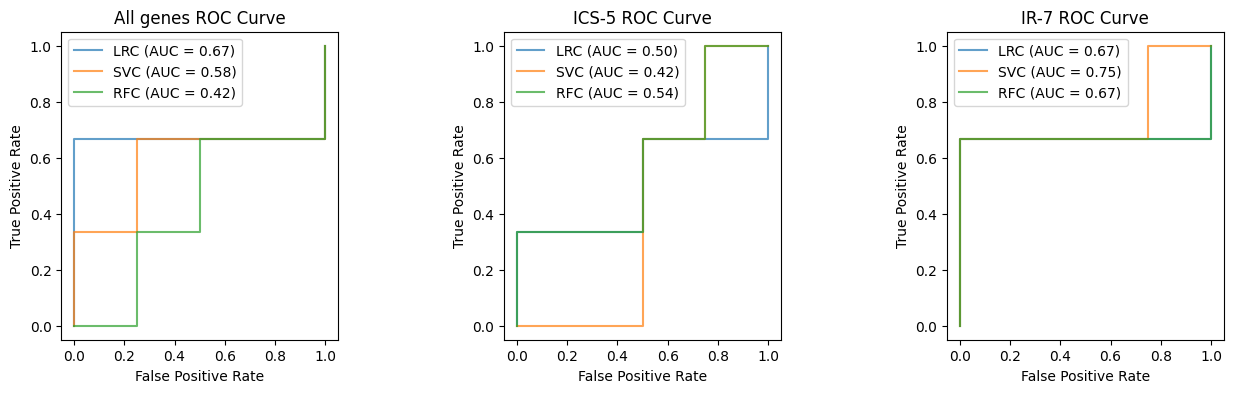

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}


# set up plots
fig, ax = plt.subplots(1, len(gene_list), figsize = (15, 4))
plt.subplots_adjust(wspace = 0.6)


count = 0

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_B_train, R_B_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  R_N_train, R_N_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] != 'HER2'], random_state=0)
  N_B_train, N_B_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  N_N_train, N_N_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] != 'HER2'], random_state=0)

  # get samples
  train_samp = list(R_B_train) + list(R_N_train) + list(N_B_train) + list(N_N_train)
  test_samp = list(R_B_test) + list(R_N_test) + list(N_B_test) + list(N_N_test)
  
  # get labels
  train_labels = HR_samp.recur[train_samp]
  test_labels = HR_samp.recur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  # get the log probabilities
  proba_lr = lr.predict_proba(condition1_data[test_samp].T)
  proba_sv = sv.predict_proba(condition1_data[test_samp].T)
  proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

  # add labels
  proba_lr = pd.DataFrame(proba_lr, index = test_samp,
                          columns = lr.classes_)
  
  proba_sv = pd.DataFrame(proba_sv, index = test_samp,
                          columns = sv.classes_)
  
  proba_rfc = pd.DataFrame(proba_rfc, index = test_samp,
                          columns = rfc.classes_)

  # pull out the column associated with positive
  proba_lr = proba_lr[True]
  proba_sv = proba_sv[True]
  proba_rfc = proba_rfc[True]

  auc_values = {'lr':0, 'sv':0, 'rfc':0}
  for name_c, proba_c in {'lr':proba_lr, 'sv':proba_sv, 'rfc':proba_rfc}.items():

    # get the ROC data
    fpr, tpr, roc_thresh = metrics.roc_curve(test_labels, proba_c)

    # get the AUC
    roc_auc = metrics.auc(fpr, tpr)

    auc_values[name_c] = roc_auc
    
    # plot the ROC curve
    ax[count].step(fpr, tpr, alpha=0.7)
    ax[count].set_xlabel('False Positive Rate')
    ax[count].set_ylabel('True Positive Rate')
    ax[count].set_title('%s ROC Curve'%(name))
    ax[count].legend(["LRC (AUC = %.2f)"%(auc_values['lr']), "SVC (AUC = %.2f)"%(auc_values['sv']), "RFC (AUC = %.2f)"%(auc_values['rfc'])], loc ="best")

  count += 1

#plt.legend()
plt.show()

## Score Plots

In [ ]:
sample_table

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


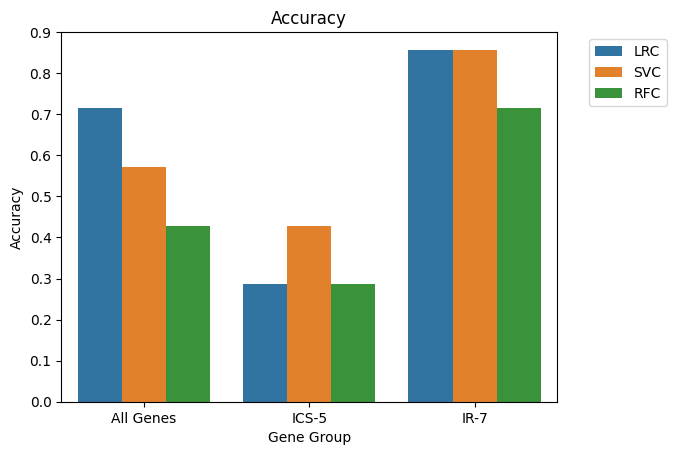

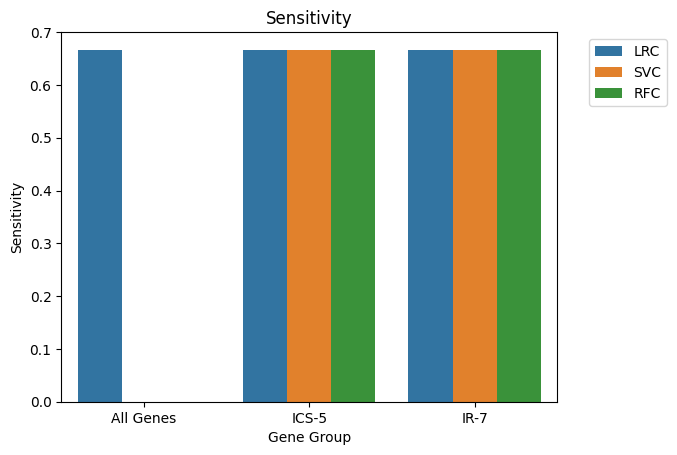

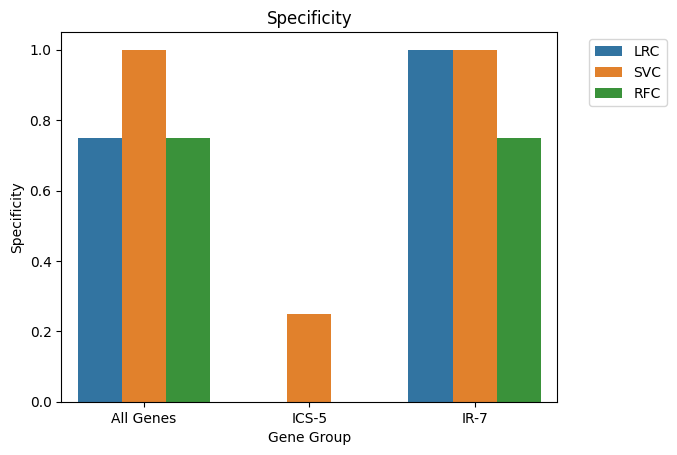

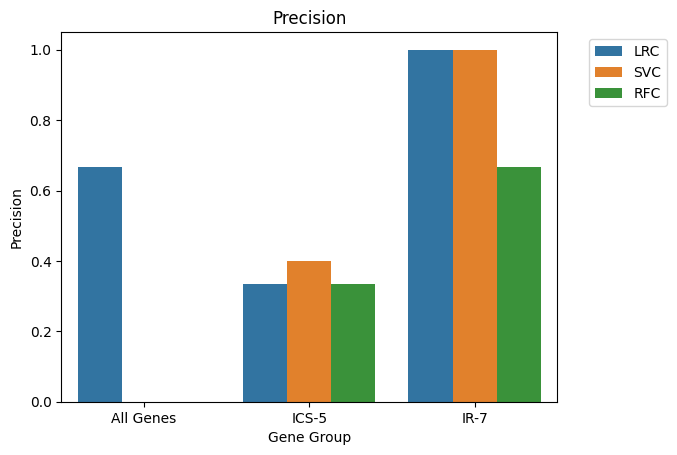

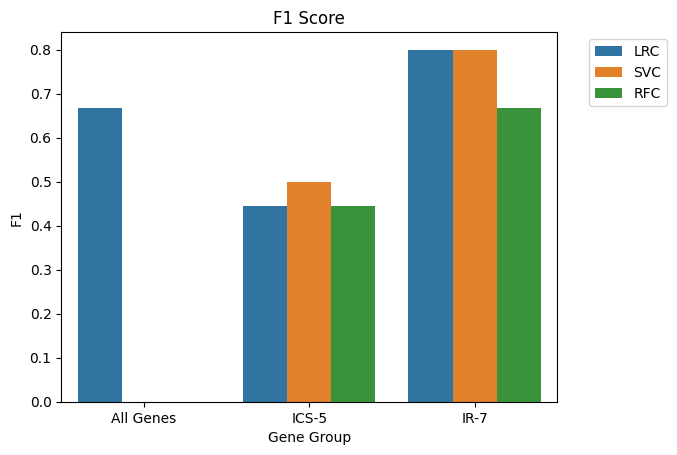

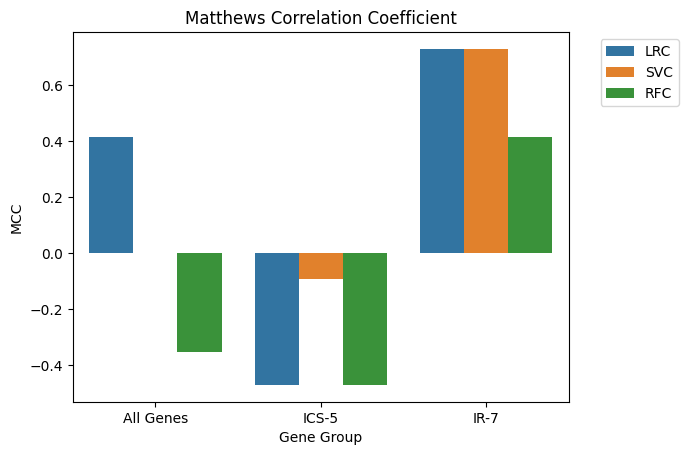

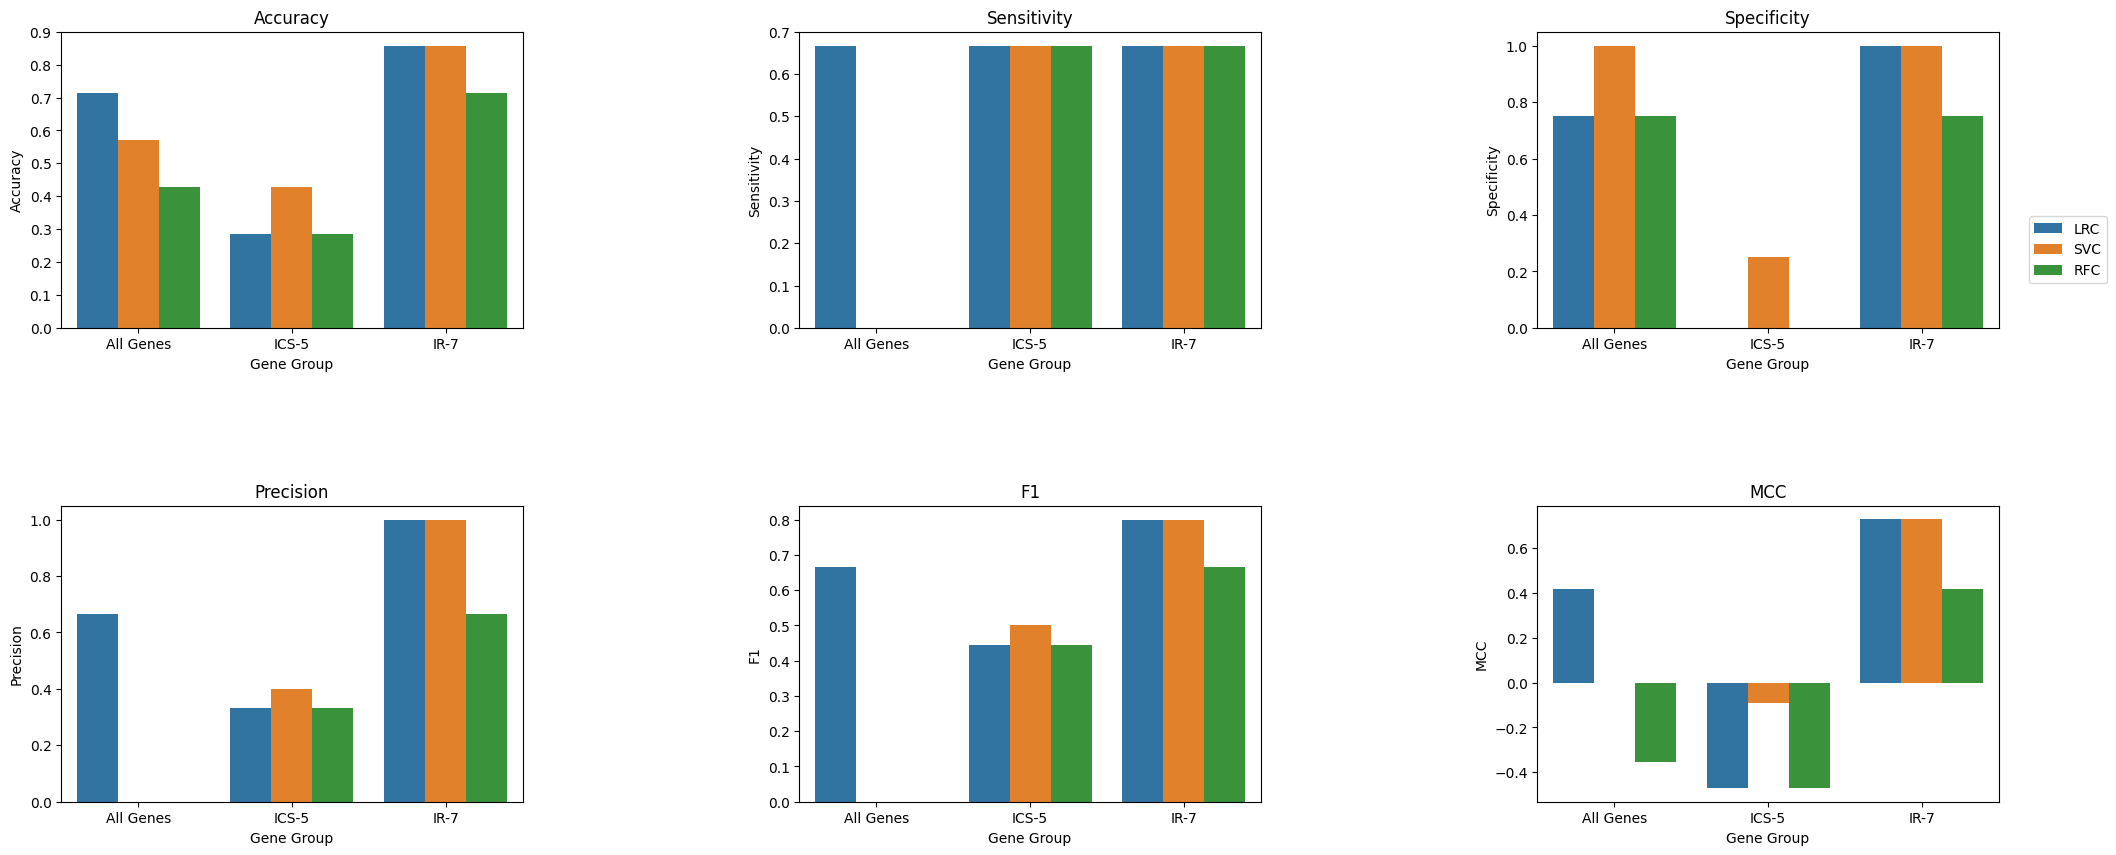

In [ ]:
gene_list = {'All Genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
         'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']}

count = 0

score_list = []

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Hormone status'] == 0]

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
   # get the splits
  R_B_train, R_B_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  R_N_train, R_N_test = model_selection.train_test_split(R_samp.index[R_samp['Cancer Subtype'] != 'HER2'], random_state=0)
  N_B_train, N_B_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] == 'Triple Negative'], random_state=0)
  N_N_train, N_N_test = model_selection.train_test_split(N_samp.index[N_samp['Cancer Subtype'] != 'HER2'], random_state=0)

  # get samples
  train_samp = list(R_B_train) + list(R_N_train) + list(N_B_train) + list(N_N_train)
  test_samp = list(R_B_test) + list(R_N_test) + list(N_B_test) + list(N_N_test)
  
  # get labels
  train_labels = HR_samp.recur[train_samp]
  test_labels = HR_samp.recur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)

  auc_values = {'lr':0, 'sv':0, 'rfc':0}
  for name_c, pred in {'LRC':lr_predictions, 'SVC':sv_predictions, 'RFC':rfc_predictions}.items():

    cm = confusion_matrix(test_labels, pred)
    confusion = pd.DataFrame(cm, 
                            index=['True: N', 'True: R'], 
                            columns=['Pred: N', 'Pred: R'])

    confusion.loc['Total'] = confusion.sum()
    confusion['Total'] = confusion.sum(axis = 1)

    # get the needed values
    tp = confusion.loc['True: R', 'Pred: R']
    tn = confusion.loc['True: N', 'Pred: N']
    fp = confusion.loc['True: N', 'Pred: R']
    fn = confusion.loc['True: R', 'Pred: N']
    all_ = confusion.loc['Total', 'Total']

    accuracy = (tp + tn)/all_
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    precision = tp/(tp + fp)
    f1 = tp/(tp + 0.5*(fp+fn))
    mcc = metrics.matthews_corrcoef(test_labels, pred)

    score_list.append([accuracy, sensitivity, specificity, precision, f1, mcc, name, name_c])

# Dataframe of scores
score_df = pd.DataFrame(score_list, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'MCC', 'Gene Group', 'Classifier'])

# Accuracy
ax = sns.barplot(x='Gene Group', y='Accuracy', hue='Classifier', data=score_df)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Accuracy')
plt.show()

# Sensitivity
ax = sns.barplot(x='Gene Group', y='Sensitivity', hue='Classifier', data=score_df)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Sensitivity')
plt.show()

# Specificity
ax = sns.barplot(x='Gene Group', y='Specificity', hue='Classifier', data=score_df)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Specificity')
plt.show()

# Precision
ax = sns.barplot(x='Gene Group', y='Precision', hue='Classifier', data=score_df)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Precision')
plt.show()

# F1 Score
ax = sns.barplot(x='Gene Group', y='F1', hue='Classifier', data=score_df)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('F1 Score')
plt.show()

# MCC
ax = sns.barplot(x='Gene Group', y='MCC', hue='Classifier', data=score_df)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Matthews Correlation Coefficient')
plt.show()

# set up plots
fig, ax = plt.subplots(2, 3, figsize = (25, 10))
plt.subplots_adjust(wspace = 0.6, hspace=0.6)

# Accuracy
sns.barplot(x='Gene Group', y='Accuracy', hue='Classifier', data=score_df, ax=ax[0, 0])
ax[0, 0].set_title('Accuracy')


# Sensitivity
sns.barplot(x='Gene Group', y='Sensitivity', hue='Classifier', data=score_df, ax=ax[0, 1])
ax[0, 1].set_title('Sensitivity')

# Specificity
sns.barplot(x='Gene Group', y='Specificity', hue='Classifier', data=score_df, ax=ax[0, 2])
ax[0, 2].set_title('Specificity')

# Precision
sns.barplot(x='Gene Group', y='Precision', hue='Classifier', data=score_df, ax=ax[1,0])
ax[1, 0].set_title('Precision')


# F1
sns.barplot(x='Gene Group', y='F1', hue='Classifier', data=score_df, ax=ax[1,1])
ax[1, 1].set_title('F1')

# MCC
sns.barplot(x='Gene Group', y='MCC', hue='Classifier', data=score_df, ax=ax[1,2])
ax[1, 2].set_title('MCC')

for a in ax:
    a[0].legend([],[], frameon=False)
    a[1].legend([],[], frameon=False)
    a[2].legend([],[], frameon=False)

plt.legend(bbox_to_anchor=(1.05,2), loc=2)
plt.show()

In [ ]:
sample_table

,Recurrence,Cancer Subtype,Hormone status,Chemo-therapy status,GnRH therapy status,TAM therapy status,Al therapy status,BSO therapy status,recur,nonrecur
Sample ID,,,,,,,,,,
C1,R,Triple Negative,0,D,N,N,N,N,True,False
C2,R,Triple Negative,0,A,N,N,N,N,True,False
C3,R,Triple Negative,0,A,N,N,N,N,True,False
C4,R,Triple Negative,0,A,N,N,N,N,True,False
C5,R,Luminal A,1,D,B,B,N,N,True,False
...,...,...,...,...,...,...,...,...,...,...
C92,N,Luminal A,1,A,N,N,N,N,False,True
C93,N,Luminal A,1,D,N,B,N,N,False,True
C94,N,Luminal A,1,A,N,B,N,N,False,True


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


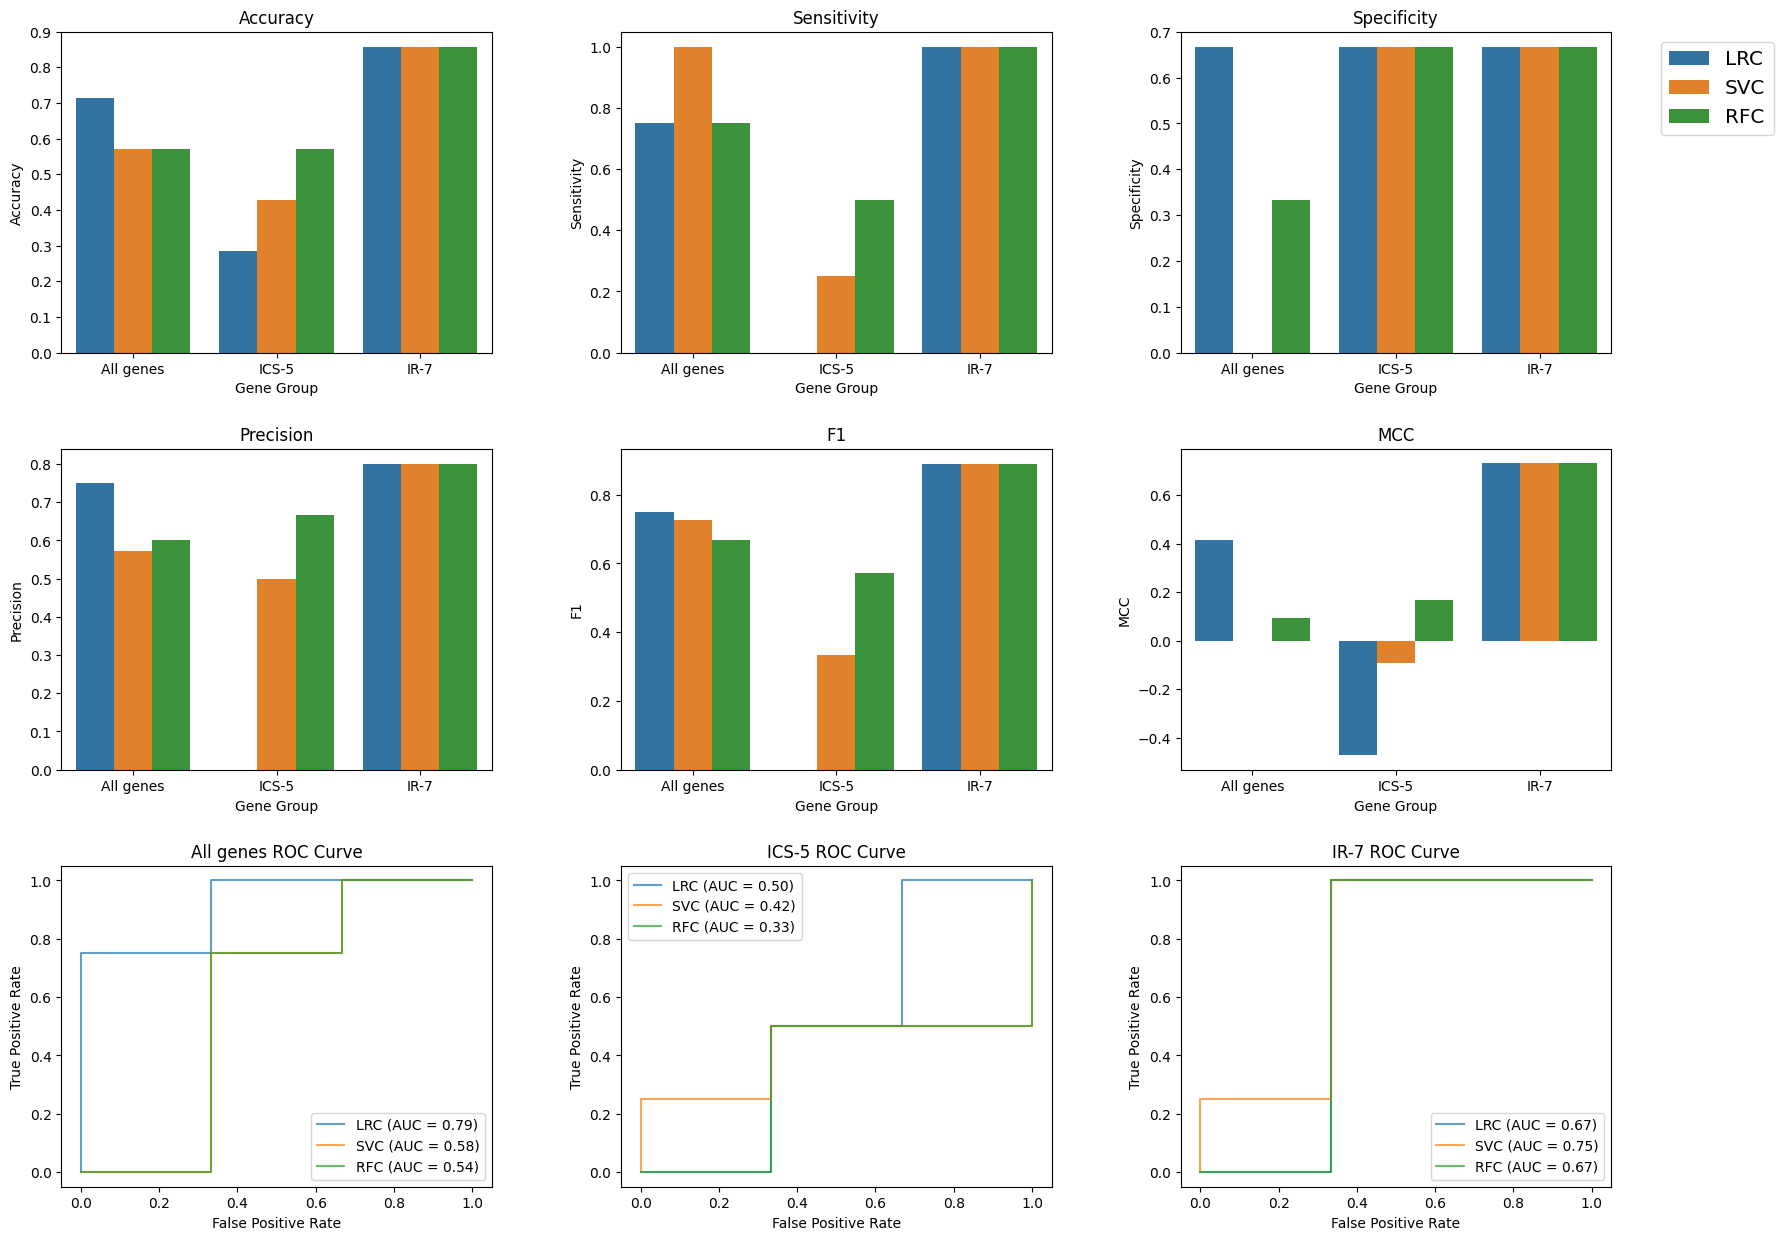

In [ ]:
gene_list = {'All genes':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21','TNFRSF17','SPP1','CIQA','IGCL2','LY9','HLA-F'],
         #'BUCK-14':['CXCL13','CLIC5','RPS28','RGS4','ABO','EXOC7','HRBL','HAPLN1','MATN1','PRRG3','PRTN3','RFX7','SSX3','ZSCAN21'],
         #'BUCK4':['CXCL13','CLIC5','RPS28','RGS4'], 
          'ICS-5':['CXCL13','XCL2','HLA-F','TNFRSF17','CLIC5'],
         'IR-7':['XCL2', 'HLA-F','TNFRSF17','SPP1','CIQA','IGCL2','LY9']
        }


# set up plots
fig, ax = plt.subplots(3, len(gene_list), figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

score_list = []
count = 0
auc_values = {'All genes':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK-14':{'lr':0, 'sv':0, 'rfc':0}, 'BUCK4':{'lr':0, 'sv':0, 'rfc':0}, 
         'ICS-5':{'lr':0, 'sv':0, 'rfc':0},
         'IR-7':{'lr':0, 'sv':0, 'rfc':0}}

for name, genes in gene_list.items():
  condition1_data = cancer_data[cancer_data.index.isin(genes)]

  # get HR Negative samples
  HR_samp = sample_table[sample_table['Cancer Subtype'] == 'Triple Negative']

  #HR_samp['recur'] = HR_samp['Recurrence Status'].str.contains('R')

  # get samples for recurrence and non-recurrence
  R_samp = HR_samp[HR_samp['Recurrence'] == 'R']
  N_samp = HR_samp[HR_samp['Recurrence'] == 'N']
  
  # get the splits
  R_train, R_test = model_selection.train_test_split(R_samp.index, random_state=0)
  N_train, N_test = model_selection.train_test_split(N_samp.index, random_state=0)
  
  # get samples
  train_samp = list(R_train) + list(N_train)
  test_samp = list(R_test) + list(N_test)
  
  # get labels
  train_labels = HR_samp.nonrecur[train_samp]
  test_labels = HR_samp.nonrecur[test_samp]  

  # train the models
  lr = linear_model.LogisticRegression(penalty = 'none').fit(condition1_data[train_samp].T, train_labels)
  sv = SVC(kernel = 'linear', probability=True).fit(condition1_data[train_samp].T, train_labels)
  rfc = RandomForestClassifier().fit(condition1_data[train_samp].T, train_labels)


  # predict class labels for the testing set
  lr_predictions = lr.predict(condition1_data[test_samp].T)
  lr_predictions = pd.Series(lr_predictions, index = test_samp)

  sv_predictions = sv.predict(condition1_data[test_samp].T)
  sv_predictions = pd.Series(sv_predictions, index = test_samp)

  rfc_predictions = rfc.predict(condition1_data[test_samp].T)
  rfc_predictions = pd.Series(rfc_predictions, index = test_samp)


  # get the log probabilities
  proba_lr = lr.predict_proba(condition1_data[test_samp].T)
  proba_sv = sv.predict_proba(condition1_data[test_samp].T)
  proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

  # add labels
  #proba_lr = pd.DataFrame(proba_lr, index = test_samp,
  #                        columns = lr.classes_)
  
  #proba_sv = pd.DataFrame(proba_sv, index = test_samp,
  #                        columns = sv.classes_)
  
  #proba_rfc = pd.DataFrame(proba_rfc, index = test_samp,
  #                        columns = rfc.classes_)

  # pull out the column associated with positive
  #proba_lr = proba_lr[True]
  #proba_sv = proba_sv[True]
  #proba_rfc = proba_rfc[True]

  for name_c, proba_c in {'lr':proba_lr, 'sv':proba_sv, 'rfc':proba_rfc}.items():

    # get the ROC data
    fpr, tpr, roc_thresh = metrics.roc_curve(test_labels, proba_c[:,1])
    #print(name_c, fpr, tpr)

    # get the AUC
    roc_auc = metrics.auc(fpr, tpr)

    auc_values[name][name_c] = roc_auc
    
    # plot the ROC curve
    ax[2, count].step(fpr, tpr, alpha=0.7)
    ax[2, count].set_xlabel('False Positive Rate')
    ax[2, count].set_ylabel('True Positive Rate')
    ax[2, count].set_title('%s ROC Curve'%(name))
    ax[2,count].legend(["LRC (AUC = %.2f)"%(auc_values[name]['lr']), "SVC (AUC = %.2f)"%(auc_values[name]['sv']), "RFC (AUC = %.2f)"%(auc_values[name]['rfc'])], loc ="best")

  count += 1

  for name_c, pred in {'LRC':lr_predictions, 'SVC':sv_predictions, 'RFC':rfc_predictions}.items():

    cm = confusion_matrix(test_labels, pred)
    confusion = pd.DataFrame(cm, 
                            index=['True: N', 'True: R'], 
                            columns=['Pred: N', 'Pred: R'])

    confusion.loc['Total'] = confusion.sum()
    confusion['Total'] = confusion.sum(axis = 1)

    # get the needed values
    tp = confusion.loc['True: R', 'Pred: R']
    tn = confusion.loc['True: N', 'Pred: N']
    fp = confusion.loc['True: N', 'Pred: R']
    fn = confusion.loc['True: R', 'Pred: N']
    all_ = confusion.loc['Total', 'Total']

    accuracy = (tp + tn)/all_
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    precision = tp/(tp + fp)
    f1 = tp/(tp + 0.5*(fp+fn))
    mcc = metrics.matthews_corrcoef(test_labels, pred)

    score_list.append([accuracy, sensitivity, specificity, precision, f1, mcc, name, name_c])

# Dataframe of scores
score_df = pd.DataFrame(score_list, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'MCC', 'Gene Group', 'Classifier'])

# Accuracy
sns.barplot(x='Gene Group', y='Accuracy', hue='Classifier', data=score_df, ax=ax[0, 0])
ax[0, 0].set_title('Accuracy')


# Sensitivity
sns.barplot(x='Gene Group', y='Sensitivity', hue='Classifier', data=score_df, ax=ax[0, 1])
ax[0, 1].set_title('Sensitivity')

# Specificity
sns.barplot(x='Gene Group', y='Specificity', hue='Classifier', data=score_df, ax=ax[0, 2])
ax[0, 2].set_title('Specificity')

# Precision
sns.barplot(x='Gene Group', y='Precision', hue='Classifier', data=score_df, ax=ax[1,0])
ax[1, 0].set_title('Precision')


# F1
sns.barplot(x='Gene Group', y='F1', hue='Classifier', data=score_df, ax=ax[1,1])
ax[1, 1].set_title('F1')

# MCC
sns.barplot(x='Gene Group', y='MCC', hue='Classifier', data=score_df, ax=ax[1,2])
ax[1, 2].set_title('MCC')

# get the log probabilities
proba_lr = lr.predict_proba(condition1_data[test_samp].T)
proba_sv = sv.predict_proba(condition1_data[test_samp].T)
proba_rfc = rfc.predict_proba(condition1_data[test_samp].T)

ax[0,0].legend([],[], frameon=False)
ax[0,1].legend([],[], frameon=False)
ax[0,2].legend(bbox_to_anchor=(1.4, 1), loc=1, fontsize='x-large')

ax[1,0].legend([],[], frameon=False)
ax[1,1].legend([],[], frameon=False)
ax[1,2].legend([],[], frameon=False)



#plt.legend(bbox_to_anchor=(1.05,2), loc=2)
plt.show()

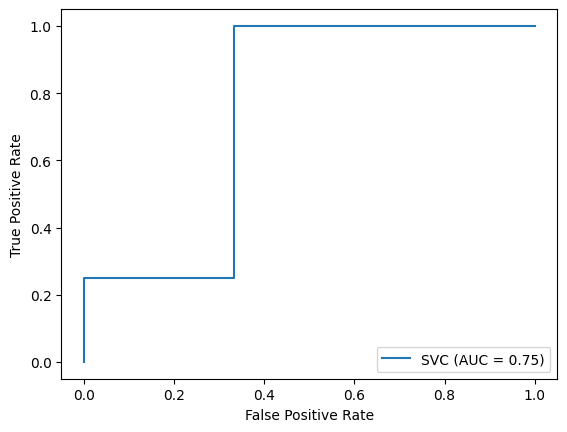

In [ ]:
svc_disp = metrics.plot_roc_curve(sv, condition1_data[test_samp].T, test_labels)
plt.show()